## Detection and Analysis of Fake News Spreader Profiles using Convolutional Neural Networks. 
Model Analysis Notebook.
Code by M. Siino. 

From the paper: "Detection and Analysis of Fake News Spreader Profiles using Convolutional Neural Networks" by M.Siino et al.



In [ ]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

from io import open
from pathlib import Path

from google.colab import files

## Importing DS and model and extract to current directory.

In [ ]:
# Url obtained starting from this: https://drive.google.com/file/d/19ZcqEv88euKB71HfAWjTGN3uCKp2qsfP/ and forcing export=download.
urlTrainingSet = "https://drive.google.com/uc?export=download&id=19ZcqEv88euKB71HfAWjTGN3uCKp2qsfP"
urlTestSet="https://drive.google.com/uc?export=download&id=1nLiYvsnqcSPsS27YrBzlFjinmXwidIYa"

training_set = tf.keras.utils.get_file("pan20-author-profiling-training-2020-02-23.zip", urlTrainingSet,
                                    extract=True, archive_format='zip',cache_dir='.',
                                    cache_subdir='')
test_set = tf.keras.utils.get_file("pan20-author-profiling-test-2020-02-23.zip", urlTestSet,
                                    extract=True, archive_format='zip',cache_dir='.',
                                    cache_subdir='')

training_set_dir = os.path.join(os.path.dirname(training_set), 'pan20-author-profiling-training-2020-02-23')
test_set_dir = os.path.join(os.path.dirname(test_set), 'pan20-author-profiling-test-2020-02-23')

print(training_set)
print(training_set_dir)

!ls -A

   8192/Unknown - 0s 0us/stepDownloading data from https://drive.google.com/uc?export=download&id=1nLiYvsnqcSPsS27YrBzlFjinmXwidIYa
   8192/Unknown - 0s 0us/step./pan20-author-profiling-training-2020-02-23.zip
./pan20-author-profiling-training-2020-02-23
.config
__MACOSX
pan20-author-profiling-test-2020-02-23
pan20-author-profiling-test-2020-02-23.zip
pan20-author-profiling-training-2020-02-23
pan20-author-profiling-training-2020-02-23.zip
sample_data


## Create Model folders, importing from Google Drive

In [ ]:
# Create folders
!mkdir model
!mkdir model/variables
!mkdir model/assets

# Assign file URLs
urlModel="https://drive.google.com/uc?export=download&id=1sp8PrRsxSwmndJoSxpg_HmSxWBFtEORW"
urlVariablesIndex="https://drive.google.com/uc?export=download&id=1dM-qII_Bq4c0xN-ELs6drpjUZ18K1i1T"
urlVariablesData="https://drive.google.com/uc?export=download&id=1szdqd4xbXRyKY7JRlUtL7A6cztWrxvZ1"

# Import model files
model = tf.keras.utils.get_file("model/saved_model.pb", urlModel,
                                    extract=False, cache_dir='.',
                                    cache_subdir='')
variablesIndex = tf.keras.utils.get_file("model/variables/variables.index", urlVariablesIndex,
                                    extract=False, cache_dir='.',
                                    cache_subdir='')
variablesData = tf.keras.utils.get_file("model/variables/variables.data-00000-of-00001", urlVariablesData,
                                    extract=False, cache_dir='.',
                                    cache_subdir='')

8192/1816 [=======================================================================================================================================] - 0s 0us/step
17235968/Unknown - 1s 0us/step

## Build folders hierarchy.

In [ ]:
### Training Folders. ###

# First level directory.
if not os.path.exists('train_dir_en'):
    os.makedirs('train_dir_en')
if not os.path.exists('train_dir_es'):
    os.makedirs('train_dir_es')

# Class labels directory.
if not os.path.exists('train_dir_en/0'):
    os.makedirs('train_dir_en/0')
if not os.path.exists('train_dir_es/0'):
    os.makedirs('train_dir_es/0')
if not os.path.exists('train_dir_en/1'):
    os.makedirs('train_dir_en/1')
if not os.path.exists('train_dir_es/1'):
    os.makedirs('train_dir_es/1')

# Make Py variables.
train_dir='train_dir_'

## Test Folders. ##
# First level directory.
if not os.path.exists('test_dir_en'):
    os.makedirs('test_dir_en')
if not os.path.exists('test_dir_es'):
    os.makedirs('test_dir_es')

# Class labels directory.
if not os.path.exists('test_dir_en/0'):
    os.makedirs('test_dir_en/0')
if not os.path.exists('test_dir_es/0'):
    os.makedirs('test_dir_es/0')
if not os.path.exists('test_dir_en/1'):
    os.makedirs('test_dir_en/1')
if not os.path.exists('test_dir_es/1'):
    os.makedirs('test_dir_es/1')

# Make Py variables.
test_dir='test_dir_'

!ls -A

.config
__MACOSX
model
pan20-author-profiling-test-2020-02-23
pan20-author-profiling-test-2020-02-23.zip
pan20-author-profiling-training-2020-02-23
pan20-author-profiling-training-2020-02-23.zip
sample_data
test_dir_en
test_dir_es
train_dir_en
train_dir_es


## Set language and directories path.


In [ ]:
# Set en or es train_dir and test_dir.
language='es'

truth_file_training_dir=training_set_dir+'/'+language+'/'
truth_file_training_path = truth_file_training_dir+'truth.txt'

truth_file_test_dir=test_set_dir
truth_file_test_path = truth_file_test_dir+'/'+language+'.txt'

## Read truth.txt to organize training dataset folders.



In [ ]:
# Open the file truth.txt with read only permit.
f = open(truth_file_training_path, "r")
# use readline() to read the first line 
line = f.readline()
# use the read line to read further.
# If the file is not empty keep reading one line
# at a time, till the file is empty
while line:
    # Split line at :::
    x = line.split(":::")
    fNameXml = x[0]+'.xml'
    fNameTxt = x[0]+'.txt'
    # Second coord [0] gets just the first character (label) and not /n too.
    label = x[1][0]

    # Now move the file to the right folder.
    if os.path.exists(truth_file_training_dir+fNameXml):
      os.rename(truth_file_training_dir+fNameXml, './train_dir_'+language+'/'+label+'/'+fNameTxt )

    # use readline() to read next line
    line = f.readline()

## Read truth.txt to organize test dataset folders.

In [ ]:
# Open the file truth.txt with read only permit.
f = open(truth_file_test_path, "r")
# use readline() to read the first line 
line = f.readline()
# use the read line to read further.
# If the file is not empty keep reading one line
# at a time, till the file is empty
while line:
    # Split line at :::
    x = line.split(":::")
    fNameXml = x[0]+'.xml'
    fNameTxt = x[0]+'.txt'
    # Second coord [0] gets just the first character (label) and not /n too.
    label = x[1][0]

    # Now move the file to the right folder.
    if os.path.exists(truth_file_test_dir+'/'+language+'/'+fNameXml):
      os.rename(truth_file_test_dir+'/'+language+'/'+fNameXml, './test_dir_'+language+'/'+label+'/'+fNameTxt )

    # use readline() to read next line
    line = f.readline()

## Creating raw training DS.

In [ ]:
raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    train_dir+language, 
    batch_size=300
    )

Found 300 files belonging to 2 classes.


## Creating raw test DS.

In [ ]:
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    test_dir+language, 
    batch_size=200 
    )

Found 200 files belonging to 2 classes.


##Elisa's function to pre-process text.

In [ ]:
@tf.keras.utils.register_keras_serializable(
    package='Custom', name=None
)

def custom_standardization(input_data):
  tag_open_CDATA_removed = tf.strings.regex_replace(input_data, '<\!\[CDATA\[', ' <')
  tag_open_document_removed = tf.strings.regex_replace(tag_open_CDATA_removed, '<document>', '')
  tag_closed_document_removed = tf.strings.regex_replace(tag_open_document_removed, '</document>\n(\t){0,2}', '> ')
  tag_open_documents_removed  = tf.strings.regex_replace(tag_closed_document_removed, '<documents>\n(\t){0,2}', ' <')
  tag_closed_documents_removed = tf.strings.regex_replace(tag_open_documents_removed, '</documents>\n(\t){0,2}', '> ')
  tag_closed_CDATA_removed = tf.strings.regex_replace(tag_closed_documents_removed,'\]{1,}>', '')
  formatting_removed = tf.strings.regex_replace(tag_closed_CDATA_removed, '<author lang="es">\n\t', '<author_lang="es">')
  keeping_tweet_style = tf.strings.regex_replace(formatting_removed, '\n', ' \n')
  output_data = tf.strings.regex_replace(keeping_tweet_style, 'ht\w{0,3}:?/{0,2}…', '#URL#')
  return output_data

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds=raw_train_ds
test_ds = raw_test_ds
#train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)
#test_ds = raw_test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
# Word embedding dimensions.
# Dimensioni superiori al 32 tendono a produrre overfitting (aumenta Accuracy in Training e diminuisce in Validation).
# Dimensioni inferiori al 32 allungano i tempi per raggiungere il fitting.
embedding_dim = 32

##Model loading.

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, 4060)              0         
_________________________________________________________________
embedding_7 (Embedding)      (None, 4060, 32)          2432032   
_________________________________________________________________
dropout_21 (Dropout)         (None, 4060, 32)          0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 4029, 32)          32800     
_________________________________________________________________
max_pooling1d_14 (MaxPooling (None, 2014, 32)          0         
_________________________________________________________________
dropout_22 (Dropout)         (None, 2014, 32)          0         
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 1999, 32)         

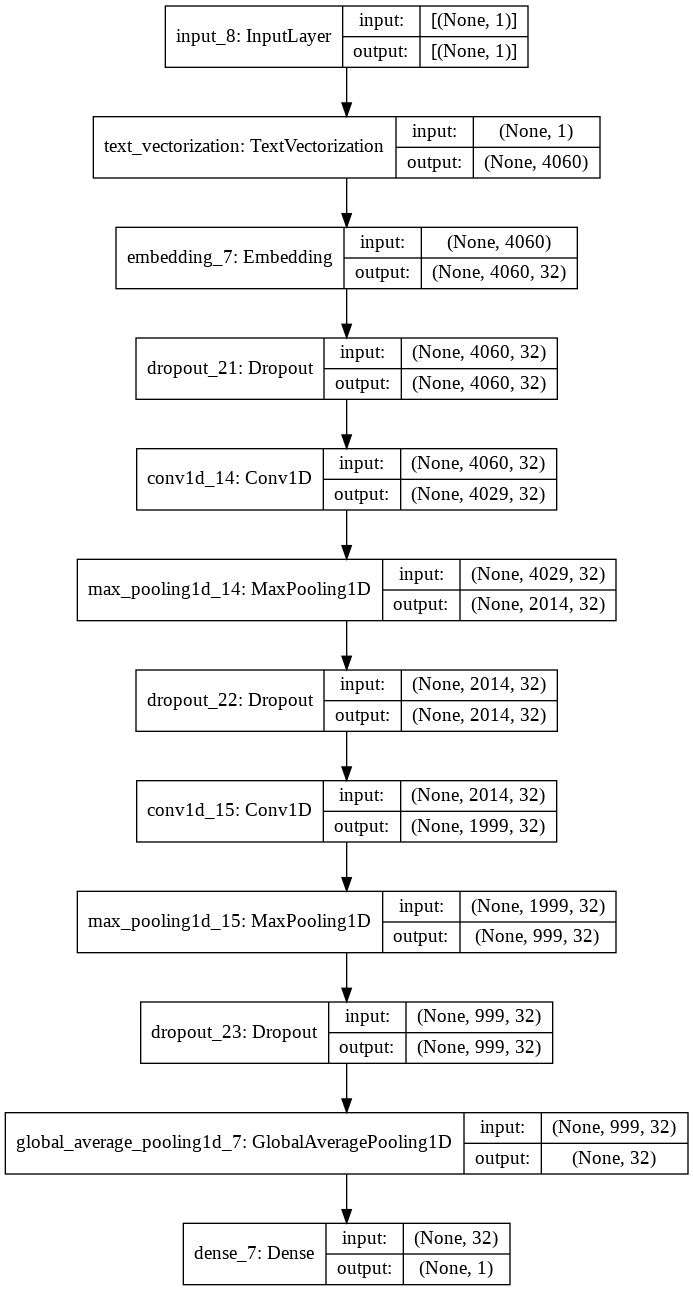

In [ ]:
model = None
with tf.keras.utils.custom_object_scope({'custom_standardization': custom_standardization}):
  model = tf.keras.models.load_model('model')

model.summary()

tf.keras.utils.plot_model(model, "my_first_model_with_shape_info.png", show_shapes=True)

## Evaluate the model on the training set.

In [ ]:
model.evaluate(train_ds)

1/1 [==============================] - 3s 3s/step - loss: 0.2123 - binary_accuracy: 0.9467


[0.21228550374507904, 0.9466666579246521]

## Evaluate the model on the test set.

In [ ]:
model.evaluate(test_ds)

1/1 [==============================] - 1s 1s/step - loss: 0.8137 - binary_accuracy: 0.8500


[0.8136865496635437, 0.8500000238418579]

##Reload training set with different batch size. 

In [ ]:
batch_size=12

seed = 1

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    train_dir+language, 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='training', 
    shuffle='false',
    seed=seed
    )

Found 300 files belonging to 2 classes.
Using 240 files for training.


##Create and adapt a vocabulary to show the data.


In [ ]:
# Maximum number of words allowed 76000 in our dictionary.
max_features = 76000
# After tokenization 4060 covers all the document lenghts in our dataset.
sequence_length = 4060

vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

## Download embedding layers vectors and metadata for Embedding Projector.

In [ ]:
import io

weights = model.get_layer('embedding_7').get_weights()[0]
vocab = vectorize_layer.get_vocabulary()
print(weights)
print(vocab)
out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(vocab):
  if  index == 0: continue # skip 0, it's padding.
  vec = weights[index] 
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()

try:
  from google.colab import files
  files.download('vectors.tsv')
  files.download('metadata.tsv')
except Exception as e:
  pass

[[-0.01641477  0.00036025  0.00547869 ...  0.00636747  0.00797666
   0.00321492]
 [ 0.01521696 -0.02018781 -0.00342009 ...  0.03552034  0.03796098
   0.01326186]
 [-0.01875445  0.01218058  0.02539301 ...  0.01871987 -0.00746809
   0.03035013]
 ...
 [ 0.04347699  0.04922709 -0.02696469 ...  0.0476425  -0.01254242
   0.04635945]
 [-0.04270096  0.03207273 -0.01835825 ... -0.01362294 -0.04452279
   0.02073264]
 [-0.0169269   0.0109551  -0.03197185 ... -0.04998237 -0.03835902
   0.03830712]]
['', '[UNK]', 'de', '#URL#>', 'la', 'en', 'que', 'a', 'y', 'el', '#USER#:', '<RT', '#URL#', 'los', '#USER#', 'un', '#HASHTAG#', 'del', 'por', 'para', 'con', 'no', 'las', 'se', 'una', 'es', 'al', '<#USER#', 'lo', '-', 'su', '#USER#>', 'El', 'más', 'La', '<El', '–', 'Unete', 'como', '<La', 'te', 'ha', 'tu', 'me', 'le', 'o', '#HASHTAG#>', 'vía', 'si', 'años', 'este', 'sus', 'son', '|', 'sobre', 'sin', 'ya', 'está', 'En', 'ser', 'esta', 'pero', 'nos', 'contra', 'No', 'De', '<#HASHTAG#', 'Los', '<VIDEO', 'ha

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##Plot output of each filter at first convolution layer. 
##Print windows of tokens associated with the maximum and minimum values of each output.


Sample considered is:  tf.Tensor(b'<author lang="es">\n\t<documents>\n\t\t<document><![CDATA[La Guerra de Vietnam, sangre y napalm #URL#]]></document>\n\t\t<document><![CDATA[Muere un ni\xc3\xb1o porque sus padres veganos solo le daban de comer frutas y verduras #URL#]]></document>\n\t\t<document><![CDATA[La prima de riesgo sube tras las elecciones y se aleja de la de Portugal #URL#]]></document>\n\t\t<document><![CDATA[Los Mossos identifican el coche de una hija de Torra en un intento de cortar las v\xc3\xadas del AVE #URL#]]></document>\n\t\t<document><![CDATA[El 61,7 por cien de encuestados cree que la sociedad balear \xe2\x80\x9cno\xe2\x80\x9d esta concienciada con el bienestar animal #URL#]]></document>\n\t\t<document><![CDATA[JxCAT teme que el apoyo de ERC en Madrid incluye un nuevo tripartito en Catalu\xc3\xb1a #URL#]]></document>\n\t\t<document><![CDATA[Un joven detenido en Palma por da\xc3\xb1os a veh\xc3\xadculos, robo con fuerza y estar en situaci\xc3\xb3n irregular en Espa\

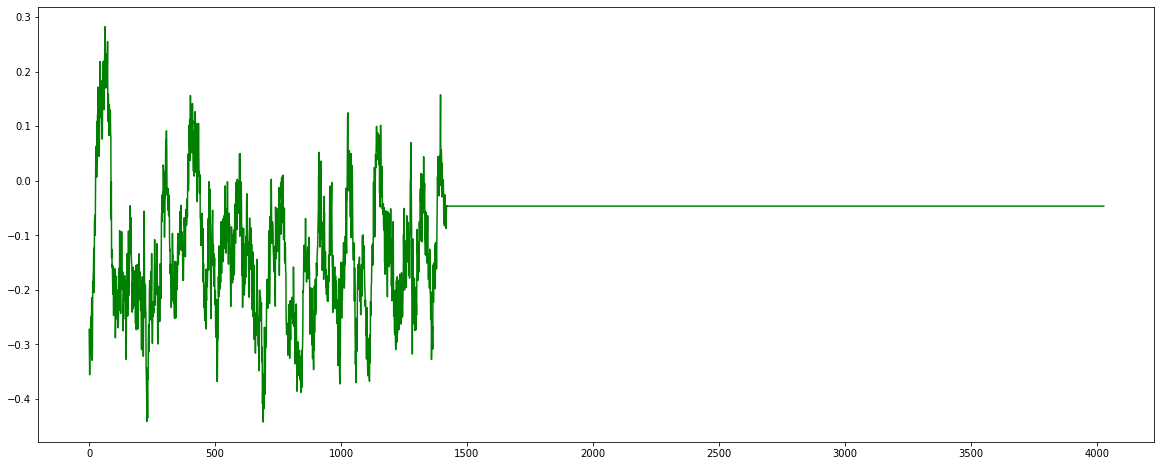


Window associated to the maximum output value (at position  63 ) is made by tokens:
[67655    18  2490     2 41390   752     6     4   610 12138 10003    60
 45058    20     9  4539  1948     3 65613 10268     6     9   461     2
  1490     5   146  2645    15    89 14357     5]
61,7 por cien de encuestados cree que la sociedad balear “no” esta concienciada con el bienestar animal #URL#> <JxCAT teme que el apoyo de ERC en Madrid incluye un nuevo tripartito en 
Window associated to the minimum output value (at position  691 ) is made by tokens:
[65624 69147 23861  1518  1382 17630   365     6 29599    53  4148  2358
     3   176   142  5231    20    15 15806 30335     7    85  7920    17
 52577    53  4148  2358     3 67318 50868 12765]
<Jover (Podemos): “Hemos perdido siete diputados. Hay que reflexionar” | CANAL4 DIARIO #URL#> <Una mujer agrede con un objeto punzante a dos técnicos del SAMU | CANAL4 DIARIO #URL#> <'GH VIP': Mila 

FILTER  2  OUTPUT: 


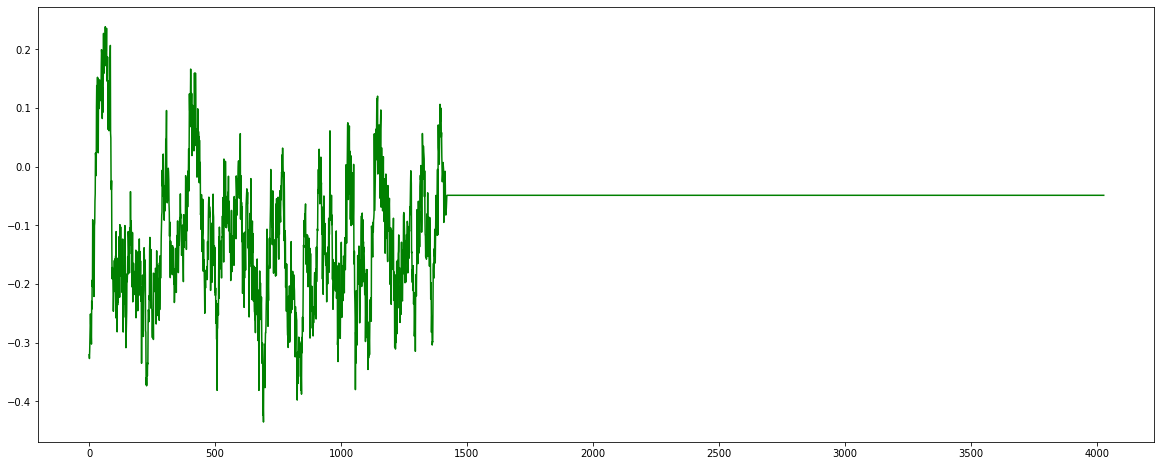


Window associated to the maximum output value (at position  64 ) is made by tokens:
[   18  2490     2 41390   752     6     4   610 12138 10003    60 45058
    20     9  4539  1948     3 65613 10268     6     9   461     2  1490
     5   146  2645    15    89 14357     5   473]
por cien de encuestados cree que la sociedad balear “no” esta concienciada con el bienestar animal #URL#> <JxCAT teme que el apoyo de ERC en Madrid incluye un nuevo tripartito en Cataluña 
Window associated to the minimum output value (at position  692 ) is made by tokens:
[69147 23861  1518  1382 17630   365     6 29599    53  4148  2358     3
   176   142  5231    20    15 15806 30335     7    85  7920    17 52577
    53  4148  2358     3 67318 50868 12765    23]
(Podemos): “Hemos perdido siete diputados. Hay que reflexionar” | CANAL4 DIARIO #URL#> <Una mujer agrede con un objeto punzante a dos técnicos del SAMU | CANAL4 DIARIO #URL#> <'GH VIP': Mila se 

FILTER  3  OUTPUT: 


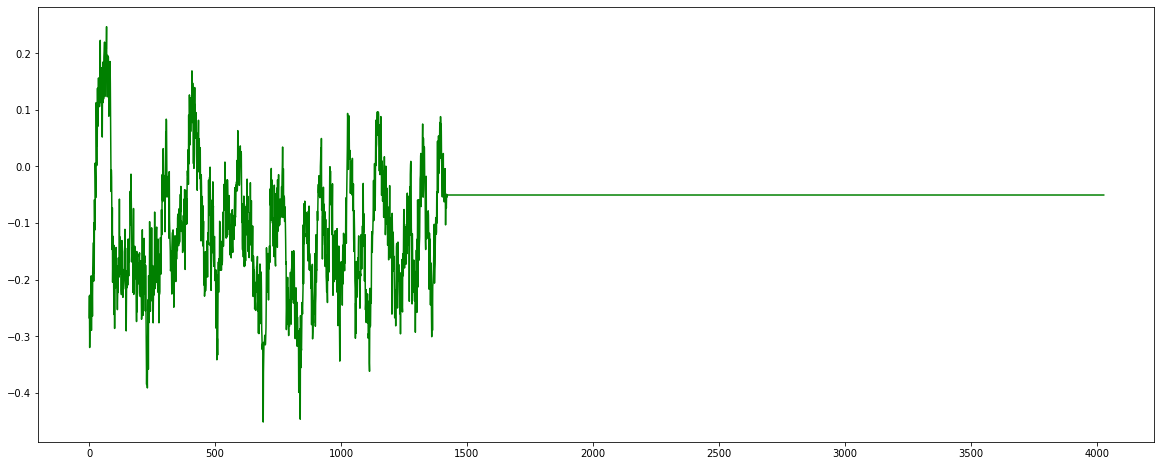


Window associated to the maximum output value (at position  69 ) is made by tokens:
[    6     4   610 12138 10003    60 45058    20     9  4539  1948     3
 65613 10268     6     9   461     2  1490     5   146  2645    15    89
 14357     5   473     3    93   272  1286     5]
que la sociedad balear “no” esta concienciada con el bienestar animal #URL#> <JxCAT teme que el apoyo de ERC en Madrid incluye un nuevo tripartito en Cataluña #URL#> <Un joven detenido en 
Window associated to the minimum output value (at position  691 ) is made by tokens:
[65624 69147 23861  1518  1382 17630   365     6 29599    53  4148  2358
     3   176   142  5231    20    15 15806 30335     7    85  7920    17
 52577    53  4148  2358     3 67318 50868 12765]
<Jover (Podemos): “Hemos perdido siete diputados. Hay que reflexionar” | CANAL4 DIARIO #URL#> <Una mujer agrede con un objeto punzante a dos técnicos del SAMU | CANAL4 DIARIO #URL#> <'GH VIP': Mila 

FILTER  4  OUTPUT: 


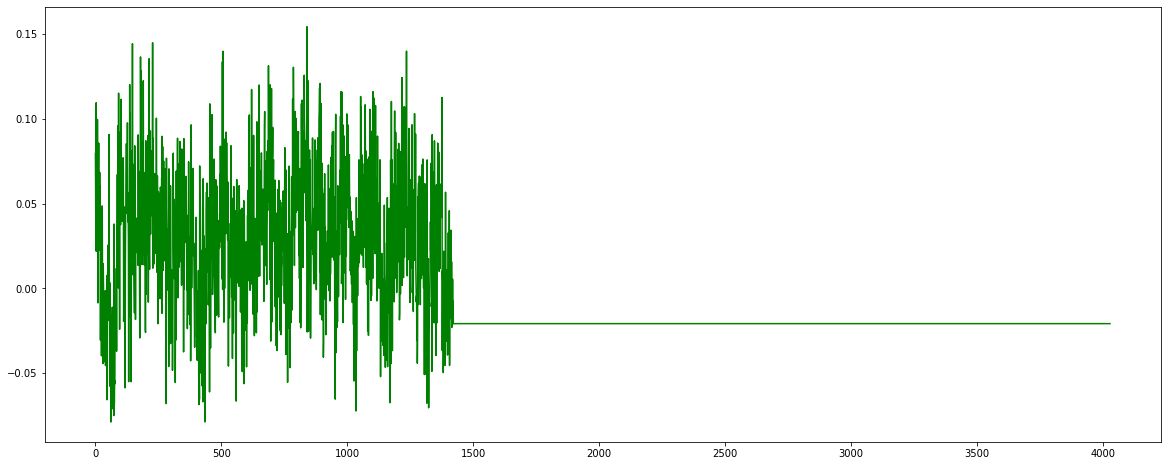


Window associated to the maximum output value (at position  840 ) is made by tokens:
[    2  2698    20  7189    53  5276 10972    29  9626  9183     3 13622
  1043   235     9  2974     2   103    98   921    85  2941     2  6777
     5 52240    18 67878   104     3    35   579]
de café con canela | Receta mexicana - Cocina Vital #URL#> <Amancio Ortega será el casero de Facebook tras comprar dos edificios de oficinas en Seattle por 375 millones #URL#> <El Gran 
Window associated to the minimum output value (at position  61 ) is made by tokens:
[    3    35 67655    18  2490     2 41390   752     6     4   610 12138
 10003    60 45058    20     9  4539  1948     3 65613 10268     6     9
   461     2  1490     5   146  2645    15    89]
#URL#> <El 61,7 por cien de encuestados cree que la sociedad balear “no” esta concienciada con el bienestar animal #URL#> <JxCAT teme que el apoyo de ERC en Madrid incluye un nuevo 

FILTER  5  OUTPUT: 


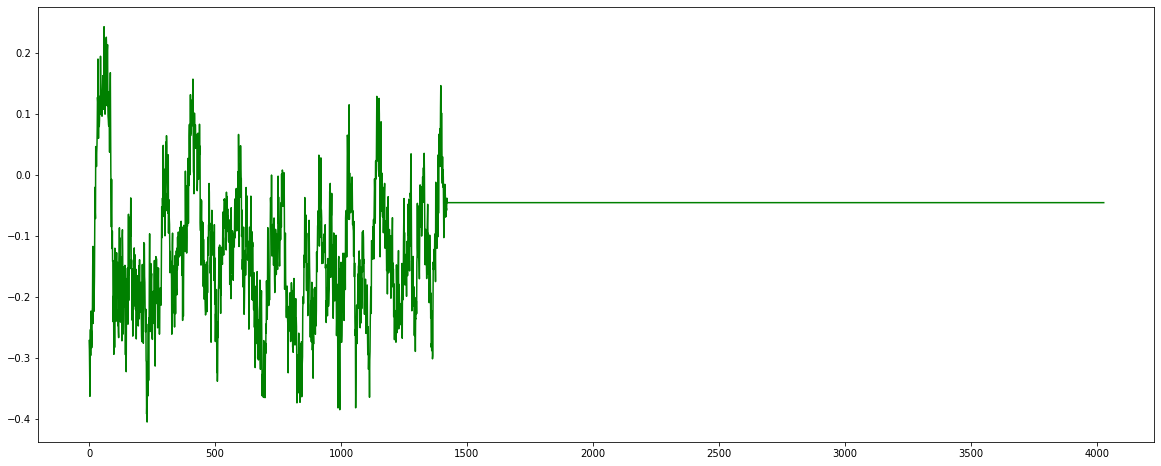


Window associated to the maximum output value (at position  59 ) is made by tokens:
[   17  5406     3    35 67655    18  2490     2 41390   752     6     4
   610 12138 10003    60 45058    20     9  4539  1948     3 65613 10268
     6     9   461     2  1490     5   146  2645]
del AVE #URL#> <El 61,7 por cien de encuestados cree que la sociedad balear “no” esta concienciada con el bienestar animal #URL#> <JxCAT teme que el apoyo de ERC en Madrid incluye 
Window associated to the minimum output value (at position  230 ) is made by tokens:
[ 3305 12829    53  4148  2358     3  3740 10401     7   133    18  8652
     9  3600  2816     3 66792 12856  1023    24 11294    55  1640     3
    39  3450     2   133    19 21116  8104     9]
Sant Llorenç | CANAL4 DIARIO #URL#> <Trump sancionará a Sánchez por financiar el comunismo venezolano #URL#> <Burger King lanza una hamburguesa sin carne #URL#> <La receta de Sánchez para Cataluña: reformar el 

FILTER  6  OUTPUT: 


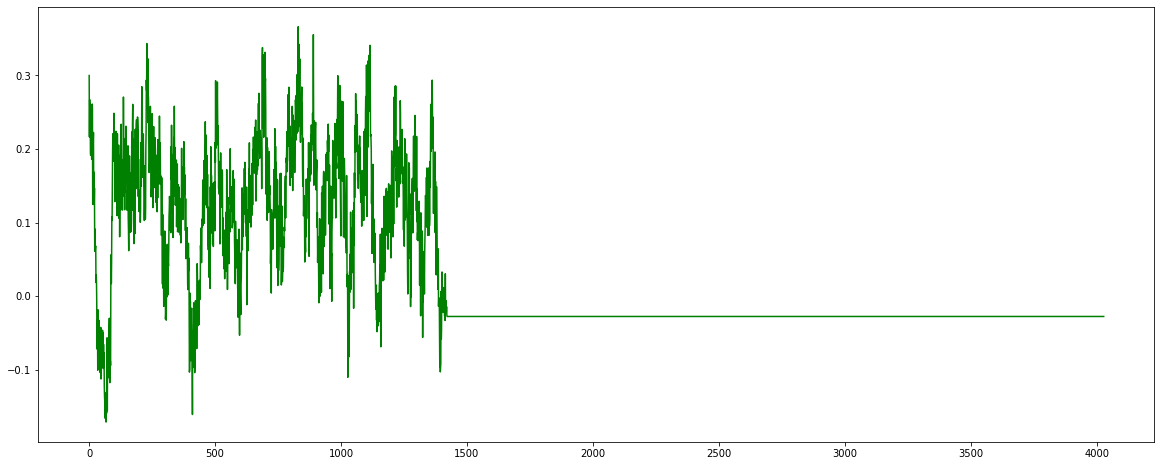


Window associated to the maximum output value (at position  830 ) is made by tokens:
[   21   260  5817   220     2   220     3   249  2260 62554     2  2698
    20  7189    53  5276 10972    29  9626  9183     3 13622  1043   235
     9  2974     2   103    98   921    85  2941]
no saber gestionar nada de nada #URL#> <Cómo preparar Atole de café con canela | Receta mexicana - Cocina Vital #URL#> <Amancio Ortega será el casero de Facebook tras comprar dos edificios 
Window associated to the minimum output value (at position  67 ) is made by tokens:
[41390   752     6     4   610 12138 10003    60 45058    20     9  4539
  1948     3 65613 10268     6     9   461     2  1490     5   146  2645
    15    89 14357     5   473     3    93   272]
encuestados cree que la sociedad balear “no” esta concienciada con el bienestar animal #URL#> <JxCAT teme que el apoyo de ERC en Madrid incluye un nuevo tripartito en Cataluña #URL#> <Un joven 

FILTER  7  OUTPUT: 


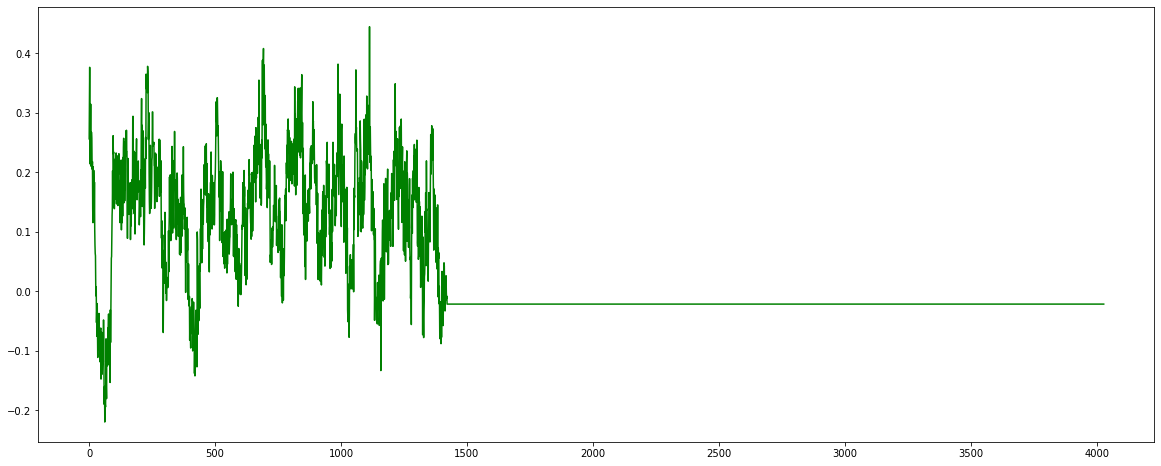


Window associated to the maximum output value (at position  1113 ) is made by tokens:
[  326     3    35  3372   861    22  3543  4442     2    22  3002 69820
    39  4872     2  9667     4 14455  1762     6  2501   294   434  1577
    32  9411     3 13601     2  3608     8 11089]
Barcelona #URL#> <El ADN revela las flores favoritas de las abejas #URL#¡> <La ruina de Bolivia, la tiranía socialista que apoya Pablo Iglesias • El Matinal #URL#> <Bizcocho de chocolate y lentejas 
Window associated to the minimum output value (at position  62 ) is made by tokens:
[   35 67655    18  2490     2 41390   752     6     4   610 12138 10003
    60 45058    20     9  4539  1948     3 65613 10268     6     9   461
     2  1490     5   146  2645    15    89 14357]
<El 61,7 por cien de encuestados cree que la sociedad balear “no” esta concienciada con el bienestar animal #URL#> <JxCAT teme que el apoyo de ERC en Madrid incluye un nuevo tripartito 

FILTER  8  OUTPUT: 


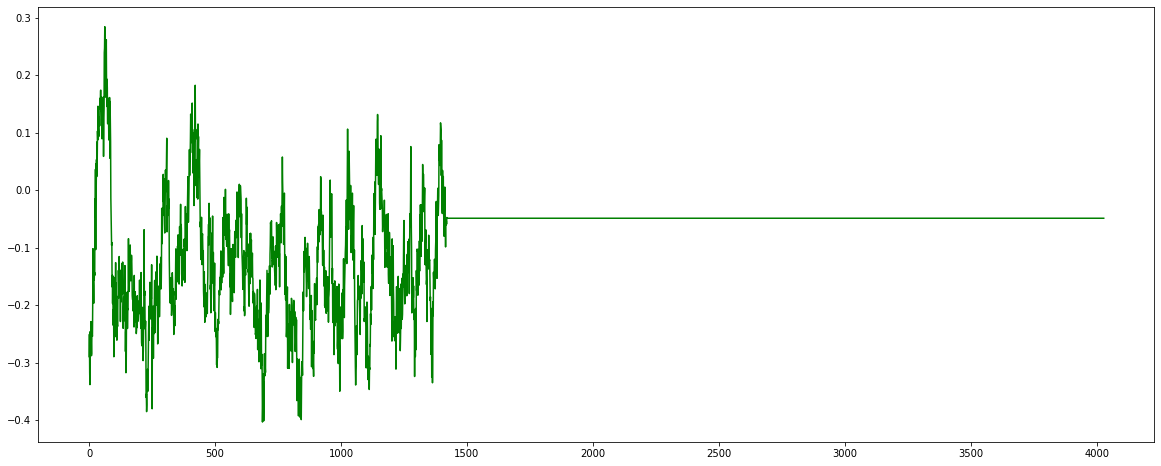


Window associated to the maximum output value (at position  62 ) is made by tokens:
[   35 67655    18  2490     2 41390   752     6     4   610 12138 10003
    60 45058    20     9  4539  1948     3 65613 10268     6     9   461
     2  1490     5   146  2645    15    89 14357]
<El 61,7 por cien de encuestados cree que la sociedad balear “no” esta concienciada con el bienestar animal #URL#> <JxCAT teme que el apoyo de ERC en Madrid incluye un nuevo tripartito 
Window associated to the minimum output value (at position  688 ) is made by tokens:
[    4 60230     3 65624 69147 23861  1518  1382 17630   365     6 29599
    53  4148  2358     3   176   142  5231    20    15 15806 30335     7
    85  7920    17 52577    53  4148  2358     3]
la DANA #URL#> <Jover (Podemos): “Hemos perdido siete diputados. Hay que reflexionar” | CANAL4 DIARIO #URL#> <Una mujer agrede con un objeto punzante a dos técnicos del SAMU | CANAL4 DIARIO #URL#> 

FILTER  9  OUTPUT: 


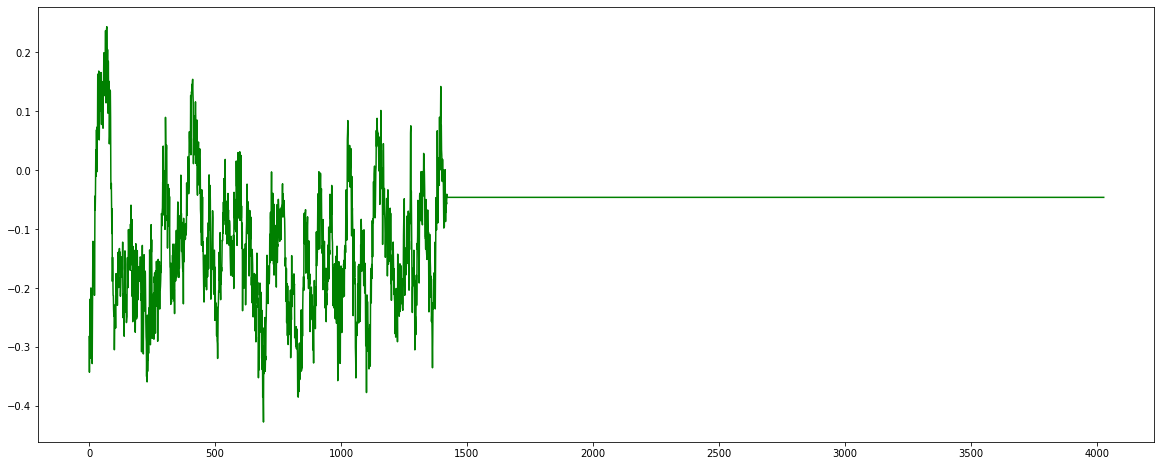


Window associated to the maximum output value (at position  70 ) is made by tokens:
[    4   610 12138 10003    60 45058    20     9  4539  1948     3 65613
 10268     6     9   461     2  1490     5   146  2645    15    89 14357
     5   473     3    93   272  1286     5  3021]
la sociedad balear “no” esta concienciada con el bienestar animal #URL#> <JxCAT teme que el apoyo de ERC en Madrid incluye un nuevo tripartito en Cataluña #URL#> <Un joven detenido en Palma 
Window associated to the minimum output value (at position  692 ) is made by tokens:
[69147 23861  1518  1382 17630   365     6 29599    53  4148  2358     3
   176   142  5231    20    15 15806 30335     7    85  7920    17 52577
    53  4148  2358     3 67318 50868 12765    23]
(Podemos): “Hemos perdido siete diputados. Hay que reflexionar” | CANAL4 DIARIO #URL#> <Una mujer agrede con un objeto punzante a dos técnicos del SAMU | CANAL4 DIARIO #URL#> <'GH VIP': Mila se 

FILTER  10  OUTPUT: 


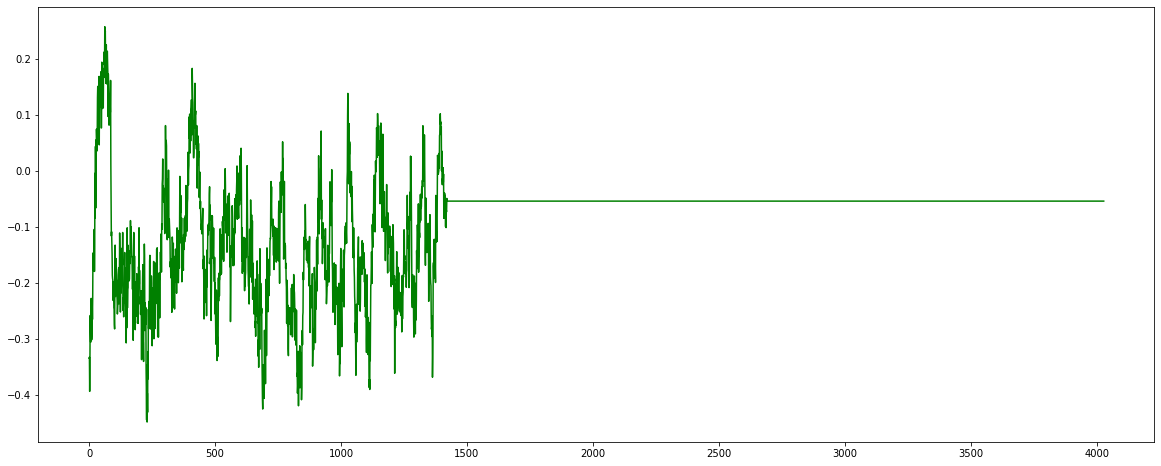


Window associated to the maximum output value (at position  62 ) is made by tokens:
[   35 67655    18  2490     2 41390   752     6     4   610 12138 10003
    60 45058    20     9  4539  1948     3 65613 10268     6     9   461
     2  1490     5   146  2645    15    89 14357]
<El 61,7 por cien de encuestados cree que la sociedad balear “no” esta concienciada con el bienestar animal #URL#> <JxCAT teme que el apoyo de ERC en Madrid incluye un nuevo tripartito 
Window associated to the minimum output value (at position  230 ) is made by tokens:
[ 3305 12829    53  4148  2358     3  3740 10401     7   133    18  8652
     9  3600  2816     3 66792 12856  1023    24 11294    55  1640     3
    39  3450     2   133    19 21116  8104     9]
Sant Llorenç | CANAL4 DIARIO #URL#> <Trump sancionará a Sánchez por financiar el comunismo venezolano #URL#> <Burger King lanza una hamburguesa sin carne #URL#> <La receta de Sánchez para Cataluña: reformar el 

FILTER  11  OUTPUT: 


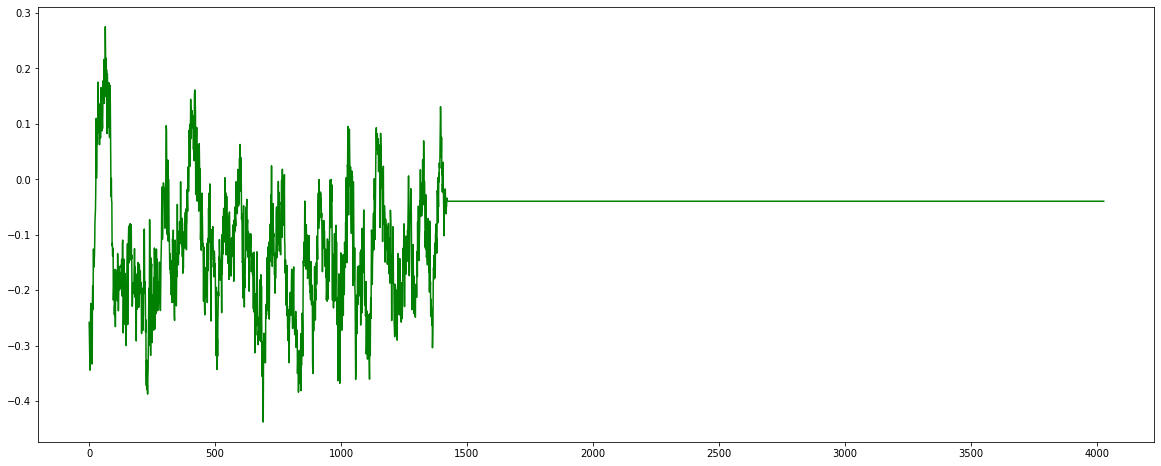


Window associated to the maximum output value (at position  64 ) is made by tokens:
[   18  2490     2 41390   752     6     4   610 12138 10003    60 45058
    20     9  4539  1948     3 65613 10268     6     9   461     2  1490
     5   146  2645    15    89 14357     5   473]
por cien de encuestados cree que la sociedad balear “no” esta concienciada con el bienestar animal #URL#> <JxCAT teme que el apoyo de ERC en Madrid incluye un nuevo tripartito en Cataluña 
Window associated to the minimum output value (at position  691 ) is made by tokens:
[65624 69147 23861  1518  1382 17630   365     6 29599    53  4148  2358
     3   176   142  5231    20    15 15806 30335     7    85  7920    17
 52577    53  4148  2358     3 67318 50868 12765]
<Jover (Podemos): “Hemos perdido siete diputados. Hay que reflexionar” | CANAL4 DIARIO #URL#> <Una mujer agrede con un objeto punzante a dos técnicos del SAMU | CANAL4 DIARIO #URL#> <'GH VIP': Mila 

FILTER  12  OUTPUT: 


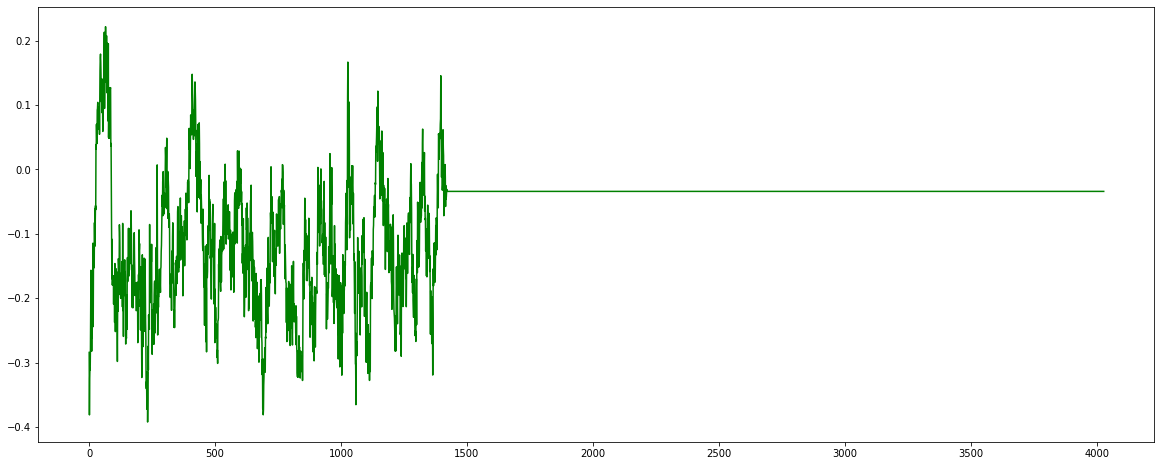


Window associated to the maximum output value (at position  65 ) is made by tokens:
[ 2490     2 41390   752     6     4   610 12138 10003    60 45058    20
     9  4539  1948     3 65613 10268     6     9   461     2  1490     5
   146  2645    15    89 14357     5   473     3]
cien de encuestados cree que la sociedad balear “no” esta concienciada con el bienestar animal #URL#> <JxCAT teme que el apoyo de ERC en Madrid incluye un nuevo tripartito en Cataluña #URL#> 
Window associated to the minimum output value (at position  232 ) is made by tokens:
[   53  4148  2358     3  3740 10401     7   133    18  8652     9  3600
  2816     3 66792 12856  1023    24 11294    55  1640     3    39  3450
     2   133    19 21116  8104     9  3353  2733]
| CANAL4 DIARIO #URL#> <Trump sancionará a Sánchez por financiar el comunismo venezolano #URL#> <Burger King lanza una hamburguesa sin carne #URL#> <La receta de Sánchez para Cataluña: reformar el Código Penal 

FILTER  13  OUTPUT: 


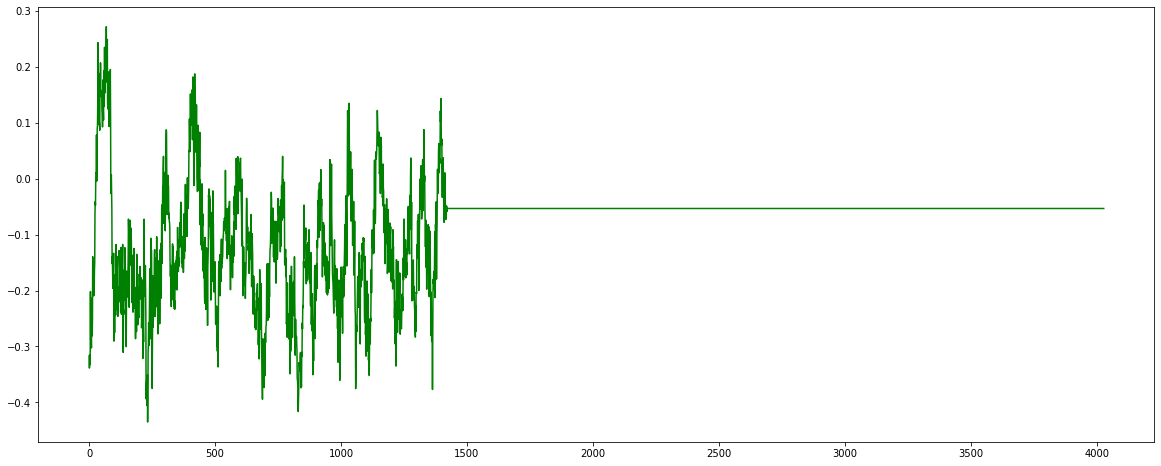


Window associated to the maximum output value (at position  68 ) is made by tokens:
[  752     6     4   610 12138 10003    60 45058    20     9  4539  1948
     3 65613 10268     6     9   461     2  1490     5   146  2645    15
    89 14357     5   473     3    93   272  1286]
cree que la sociedad balear “no” esta concienciada con el bienestar animal #URL#> <JxCAT teme que el apoyo de ERC en Madrid incluye un nuevo tripartito en Cataluña #URL#> <Un joven detenido 
Window associated to the minimum output value (at position  232 ) is made by tokens:
[   53  4148  2358     3  3740 10401     7   133    18  8652     9  3600
  2816     3 66792 12856  1023    24 11294    55  1640     3    39  3450
     2   133    19 21116  8104     9  3353  2733]
| CANAL4 DIARIO #URL#> <Trump sancionará a Sánchez por financiar el comunismo venezolano #URL#> <Burger King lanza una hamburguesa sin carne #URL#> <La receta de Sánchez para Cataluña: reformar el Código Penal 

FILTER  14  OUTPUT: 


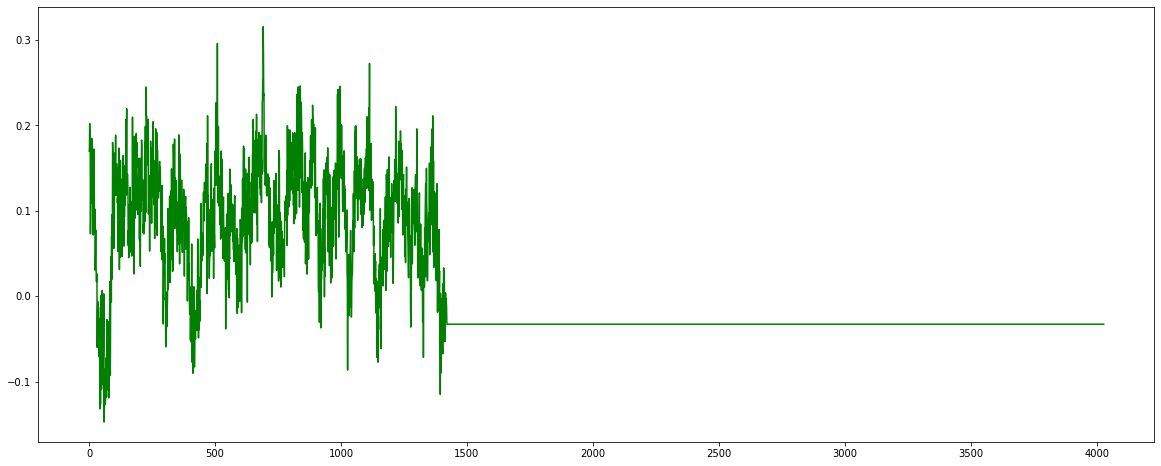


Window associated to the maximum output value (at position  691 ) is made by tokens:
[65624 69147 23861  1518  1382 17630   365     6 29599    53  4148  2358
     3   176   142  5231    20    15 15806 30335     7    85  7920    17
 52577    53  4148  2358     3 67318 50868 12765]
<Jover (Podemos): “Hemos perdido siete diputados. Hay que reflexionar” | CANAL4 DIARIO #URL#> <Una mujer agrede con un objeto punzante a dos técnicos del SAMU | CANAL4 DIARIO #URL#> <'GH VIP': Mila 
Window associated to the minimum output value (at position  59 ) is made by tokens:
[   17  5406     3    35 67655    18  2490     2 41390   752     6     4
   610 12138 10003    60 45058    20     9  4539  1948     3 65613 10268
     6     9   461     2  1490     5   146  2645]
del AVE #URL#> <El 61,7 por cien de encuestados cree que la sociedad balear “no” esta concienciada con el bienestar animal #URL#> <JxCAT teme que el apoyo de ERC en Madrid incluye 

FILTER  15  OUTPUT: 


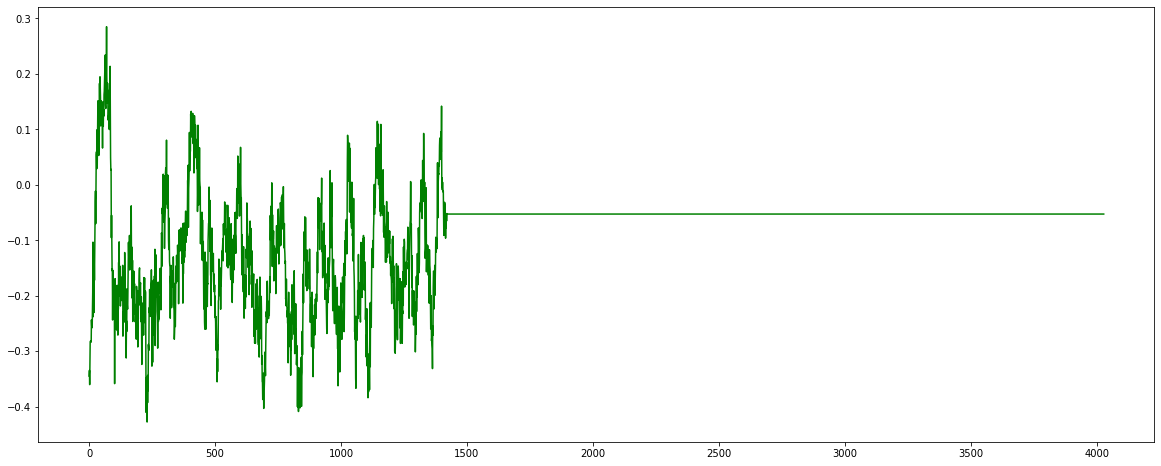


Window associated to the maximum output value (at position  69 ) is made by tokens:
[    6     4   610 12138 10003    60 45058    20     9  4539  1948     3
 65613 10268     6     9   461     2  1490     5   146  2645    15    89
 14357     5   473     3    93   272  1286     5]
que la sociedad balear “no” esta concienciada con el bienestar animal #URL#> <JxCAT teme que el apoyo de ERC en Madrid incluye un nuevo tripartito en Cataluña #URL#> <Un joven detenido en 
Window associated to the minimum output value (at position  230 ) is made by tokens:
[ 3305 12829    53  4148  2358     3  3740 10401     7   133    18  8652
     9  3600  2816     3 66792 12856  1023    24 11294    55  1640     3
    39  3450     2   133    19 21116  8104     9]
Sant Llorenç | CANAL4 DIARIO #URL#> <Trump sancionará a Sánchez por financiar el comunismo venezolano #URL#> <Burger King lanza una hamburguesa sin carne #URL#> <La receta de Sánchez para Cataluña: reformar el 

FILTER  16  OUTPUT: 


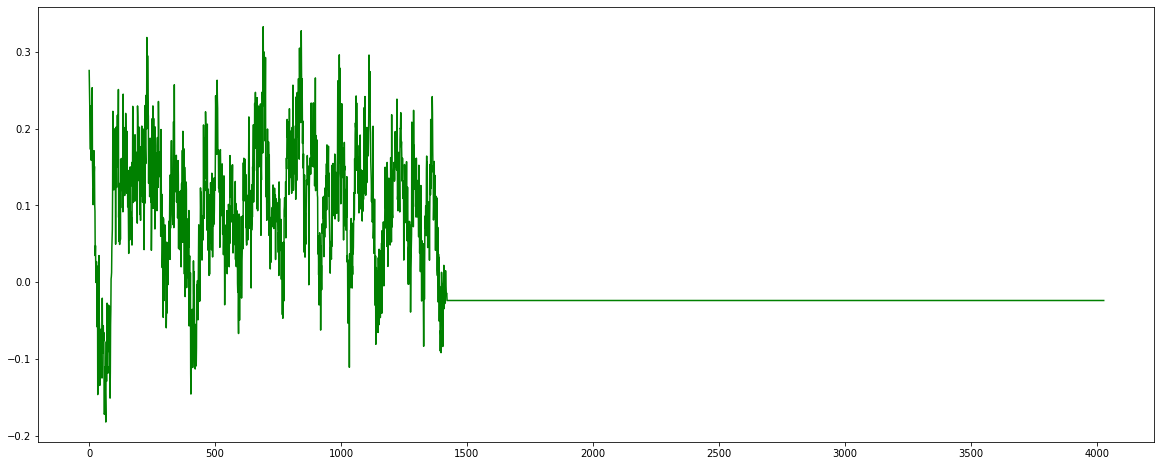


Window associated to the maximum output value (at position  691 ) is made by tokens:
[65624 69147 23861  1518  1382 17630   365     6 29599    53  4148  2358
     3   176   142  5231    20    15 15806 30335     7    85  7920    17
 52577    53  4148  2358     3 67318 50868 12765]
<Jover (Podemos): “Hemos perdido siete diputados. Hay que reflexionar” | CANAL4 DIARIO #URL#> <Una mujer agrede con un objeto punzante a dos técnicos del SAMU | CANAL4 DIARIO #URL#> <'GH VIP': Mila 
Window associated to the minimum output value (at position  66 ) is made by tokens:
[    2 41390   752     6     4   610 12138 10003    60 45058    20     9
  4539  1948     3 65613 10268     6     9   461     2  1490     5   146
  2645    15    89 14357     5   473     3    93]
de encuestados cree que la sociedad balear “no” esta concienciada con el bienestar animal #URL#> <JxCAT teme que el apoyo de ERC en Madrid incluye un nuevo tripartito en Cataluña #URL#> <Un 

FILTER  17  OUTPUT: 


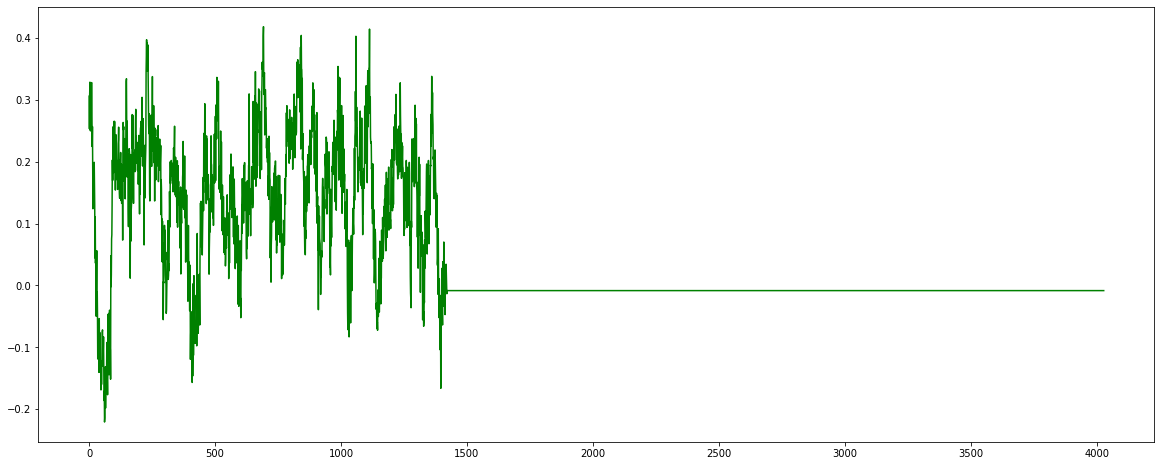


Window associated to the maximum output value (at position  692 ) is made by tokens:
[69147 23861  1518  1382 17630   365     6 29599    53  4148  2358     3
   176   142  5231    20    15 15806 30335     7    85  7920    17 52577
    53  4148  2358     3 67318 50868 12765    23]
(Podemos): “Hemos perdido siete diputados. Hay que reflexionar” | CANAL4 DIARIO #URL#> <Una mujer agrede con un objeto punzante a dos técnicos del SAMU | CANAL4 DIARIO #URL#> <'GH VIP': Mila se 
Window associated to the minimum output value (at position  61 ) is made by tokens:
[    3    35 67655    18  2490     2 41390   752     6     4   610 12138
 10003    60 45058    20     9  4539  1948     3 65613 10268     6     9
   461     2  1490     5   146  2645    15    89]
#URL#> <El 61,7 por cien de encuestados cree que la sociedad balear “no” esta concienciada con el bienestar animal #URL#> <JxCAT teme que el apoyo de ERC en Madrid incluye un nuevo 

FILTER  18  OUTPUT: 


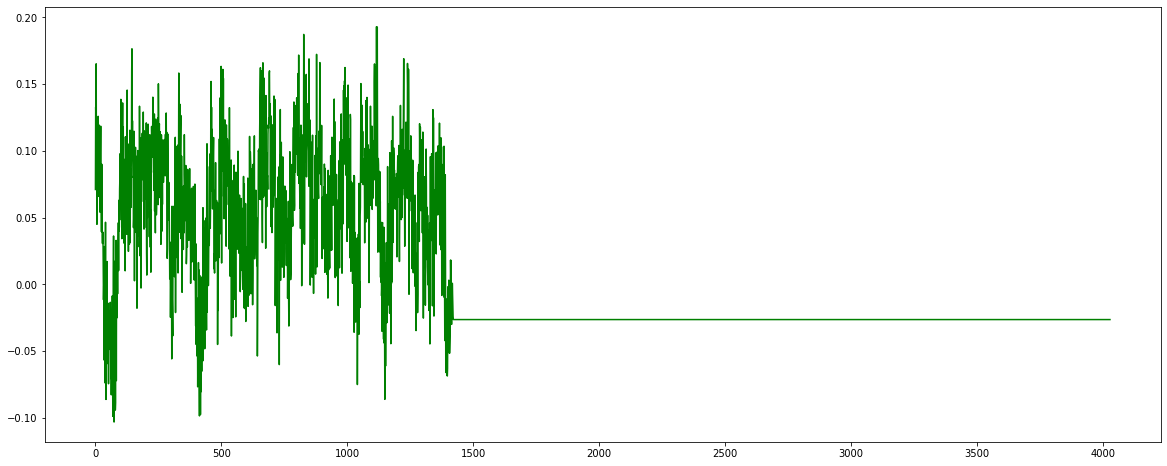


Window associated to the maximum output value (at position  1116 ) is made by tokens:
[ 3372   861    22  3543  4442     2    22  3002 69820    39  4872     2
  9667     4 14455  1762     6  2501   294   434  1577    32  9411     3
 13601     2  3608     8 11089     3    35     6]
ADN revela las flores favoritas de las abejas #URL#¡> <La ruina de Bolivia, la tiranía socialista que apoya Pablo Iglesias • El Matinal #URL#> <Bizcocho de chocolate y lentejas #URL#> <El que 
Window associated to the minimum output value (at position  74 ) is made by tokens:
[   60 45058    20     9  4539  1948     3 65613 10268     6     9   461
     2  1490     5   146  2645    15    89 14357     5   473     3    93
   272  1286     5  3021    18  1629     7 10139]
esta concienciada con el bienestar animal #URL#> <JxCAT teme que el apoyo de ERC en Madrid incluye un nuevo tripartito en Cataluña #URL#> <Un joven detenido en Palma por daños a vehículos, 

FILTER  19  OUTPUT: 


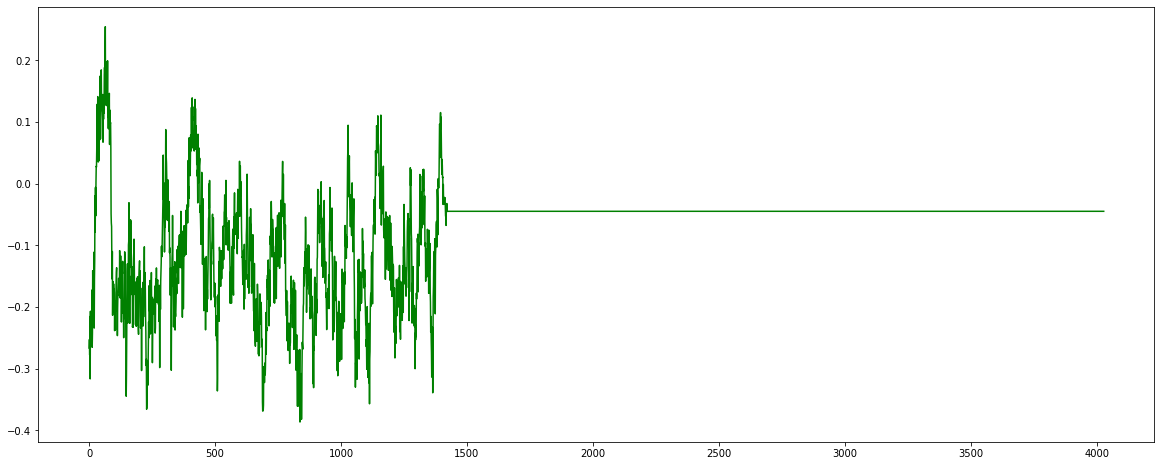


Window associated to the maximum output value (at position  64 ) is made by tokens:
[   18  2490     2 41390   752     6     4   610 12138 10003    60 45058
    20     9  4539  1948     3 65613 10268     6     9   461     2  1490
     5   146  2645    15    89 14357     5   473]
por cien de encuestados cree que la sociedad balear “no” esta concienciada con el bienestar animal #URL#> <JxCAT teme que el apoyo de ERC en Madrid incluye un nuevo tripartito en Cataluña 
Window associated to the minimum output value (at position  837 ) is made by tokens:
[  249  2260 62554     2  2698    20  7189    53  5276 10972    29  9626
  9183     3 13622  1043   235     9  2974     2   103    98   921    85
  2941     2  6777     5 52240    18 67878   104]
<Cómo preparar Atole de café con canela | Receta mexicana - Cocina Vital #URL#> <Amancio Ortega será el casero de Facebook tras comprar dos edificios de oficinas en Seattle por 375 millones 

FILTER  20  OUTPUT: 


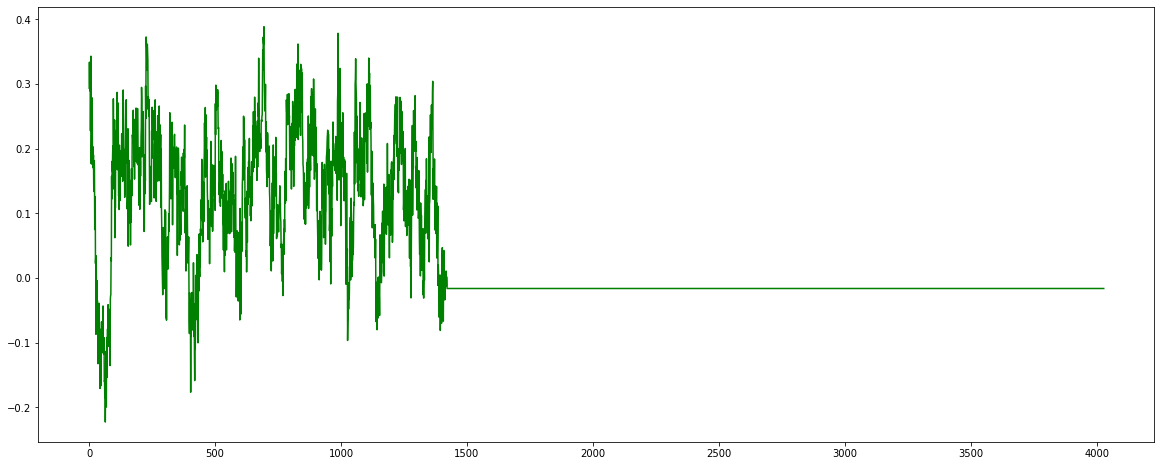


Window associated to the maximum output value (at position  694 ) is made by tokens:
[ 1518  1382 17630   365     6 29599    53  4148  2358     3   176   142
  5231    20    15 15806 30335     7    85  7920    17 52577    53  4148
  2358     3 67318 50868 12765    23   440 41448]
perdido siete diputados. Hay que reflexionar” | CANAL4 DIARIO #URL#> <Una mujer agrede con un objeto punzante a dos técnicos del SAMU | CANAL4 DIARIO #URL#> <'GH VIP': Mila se queda encerrada 
Window associated to the minimum output value (at position  64 ) is made by tokens:
[   18  2490     2 41390   752     6     4   610 12138 10003    60 45058
    20     9  4539  1948     3 65613 10268     6     9   461     2  1490
     5   146  2645    15    89 14357     5   473]
por cien de encuestados cree que la sociedad balear “no” esta concienciada con el bienestar animal #URL#> <JxCAT teme que el apoyo de ERC en Madrid incluye un nuevo tripartito en Cataluña 

FILTER  21  OUTPUT: 


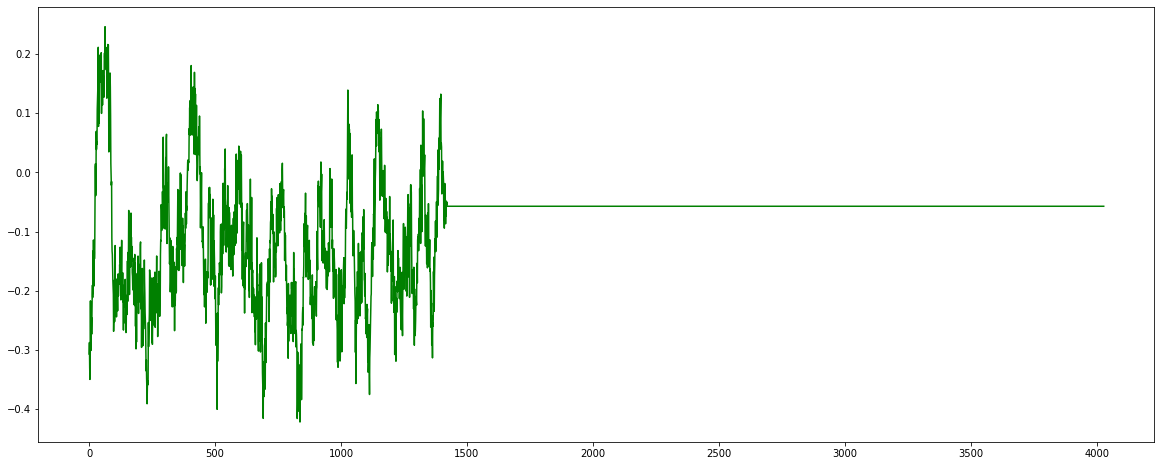


Window associated to the maximum output value (at position  63 ) is made by tokens:
[67655    18  2490     2 41390   752     6     4   610 12138 10003    60
 45058    20     9  4539  1948     3 65613 10268     6     9   461     2
  1490     5   146  2645    15    89 14357     5]
61,7 por cien de encuestados cree que la sociedad balear “no” esta concienciada con el bienestar animal #URL#> <JxCAT teme que el apoyo de ERC en Madrid incluye un nuevo tripartito en 
Window associated to the minimum output value (at position  837 ) is made by tokens:
[  249  2260 62554     2  2698    20  7189    53  5276 10972    29  9626
  9183     3 13622  1043   235     9  2974     2   103    98   921    85
  2941     2  6777     5 52240    18 67878   104]
<Cómo preparar Atole de café con canela | Receta mexicana - Cocina Vital #URL#> <Amancio Ortega será el casero de Facebook tras comprar dos edificios de oficinas en Seattle por 375 millones 

FILTER  22  OUTPUT: 


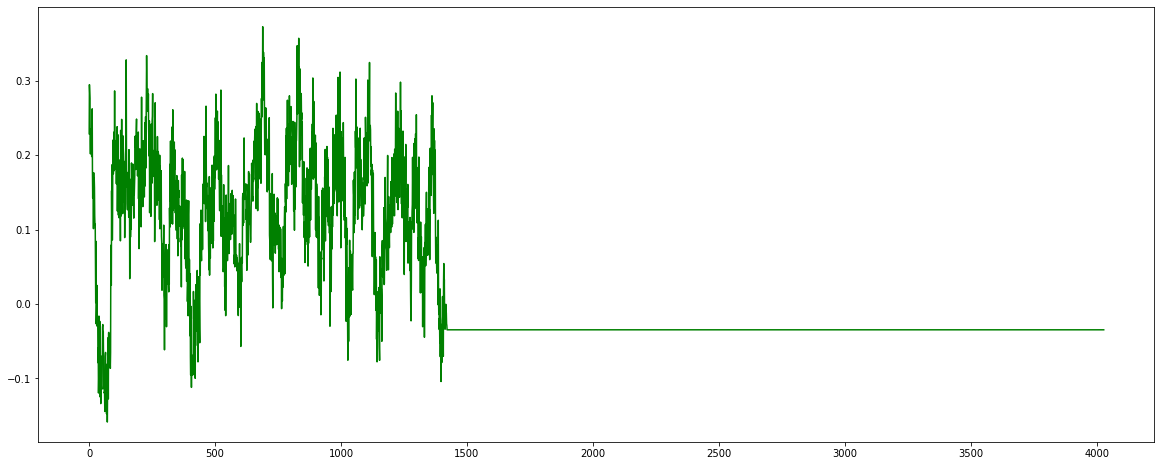


Window associated to the maximum output value (at position  689 ) is made by tokens:
[60230     3 65624 69147 23861  1518  1382 17630   365     6 29599    53
  4148  2358     3   176   142  5231    20    15 15806 30335     7    85
  7920    17 52577    53  4148  2358     3 67318]
DANA #URL#> <Jover (Podemos): “Hemos perdido siete diputados. Hay que reflexionar” | CANAL4 DIARIO #URL#> <Una mujer agrede con un objeto punzante a dos técnicos del SAMU | CANAL4 DIARIO #URL#> <'GH 
Window associated to the minimum output value (at position  72 ) is made by tokens:
[12138 10003    60 45058    20     9  4539  1948     3 65613 10268     6
     9   461     2  1490     5   146  2645    15    89 14357     5   473
     3    93   272  1286     5  3021    18  1629]
balear “no” esta concienciada con el bienestar animal #URL#> <JxCAT teme que el apoyo de ERC en Madrid incluye un nuevo tripartito en Cataluña #URL#> <Un joven detenido en Palma por daños 

FILTER  23  OUTPUT: 


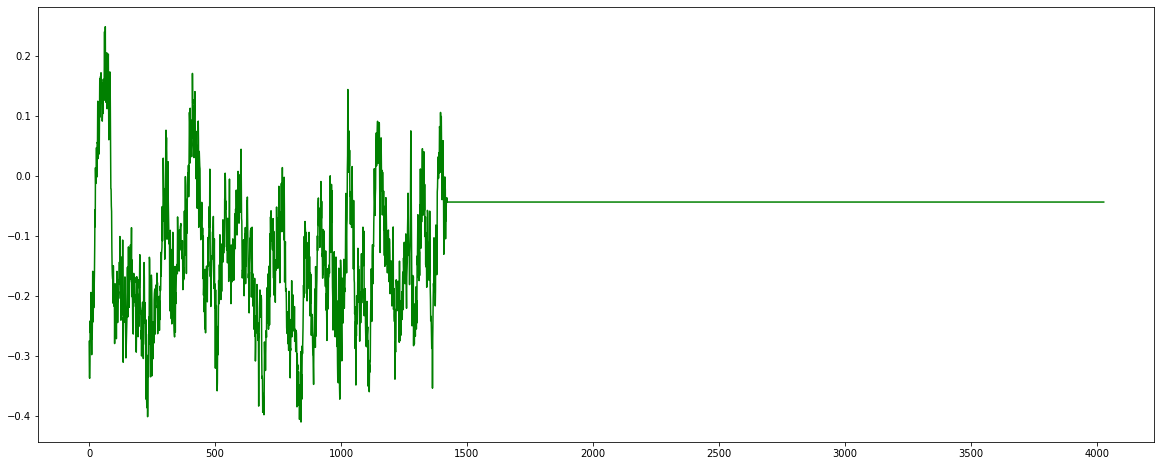


Window associated to the maximum output value (at position  64 ) is made by tokens:
[   18  2490     2 41390   752     6     4   610 12138 10003    60 45058
    20     9  4539  1948     3 65613 10268     6     9   461     2  1490
     5   146  2645    15    89 14357     5   473]
por cien de encuestados cree que la sociedad balear “no” esta concienciada con el bienestar animal #URL#> <JxCAT teme que el apoyo de ERC en Madrid incluye un nuevo tripartito en Cataluña 
Window associated to the minimum output value (at position  841 ) is made by tokens:
[ 2698    20  7189    53  5276 10972    29  9626  9183     3 13622  1043
   235     9  2974     2   103    98   921    85  2941     2  6777     5
 52240    18 67878   104     3    35   579  7494]
café con canela | Receta mexicana - Cocina Vital #URL#> <Amancio Ortega será el casero de Facebook tras comprar dos edificios de oficinas en Seattle por 375 millones #URL#> <El Gran Hermano 

FILTER  24  OUTPUT: 


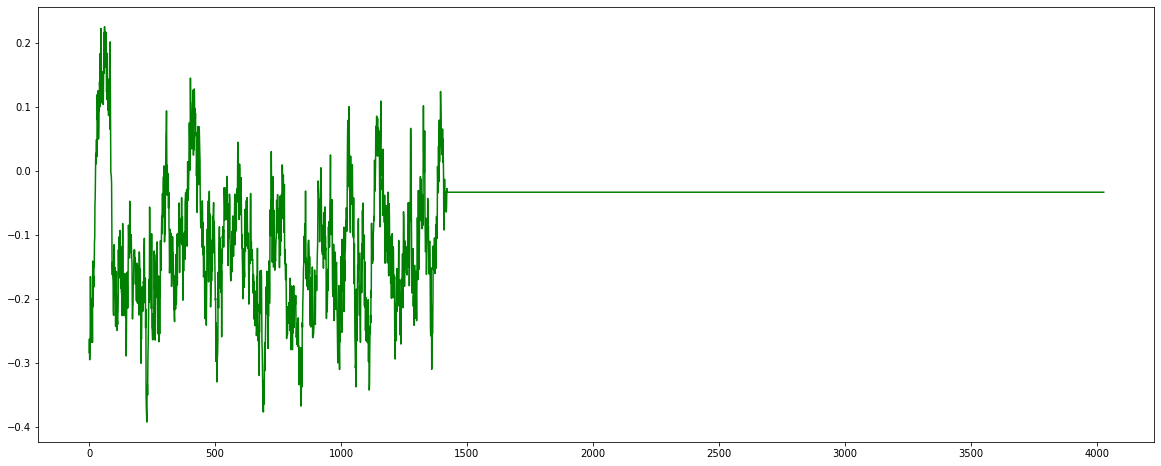


Window associated to the maximum output value (at position  61 ) is made by tokens:
[    3    35 67655    18  2490     2 41390   752     6     4   610 12138
 10003    60 45058    20     9  4539  1948     3 65613 10268     6     9
   461     2  1490     5   146  2645    15    89]
#URL#> <El 61,7 por cien de encuestados cree que la sociedad balear “no” esta concienciada con el bienestar animal #URL#> <JxCAT teme que el apoyo de ERC en Madrid incluye un nuevo 
Window associated to the minimum output value (at position  229 ) is made by tokens:
[    5  3305 12829    53  4148  2358     3  3740 10401     7   133    18
  8652     9  3600  2816     3 66792 12856  1023    24 11294    55  1640
     3    39  3450     2   133    19 21116  8104]
en Sant Llorenç | CANAL4 DIARIO #URL#> <Trump sancionará a Sánchez por financiar el comunismo venezolano #URL#> <Burger King lanza una hamburguesa sin carne #URL#> <La receta de Sánchez para Cataluña: reformar 

FILTER  25  OUTPUT: 


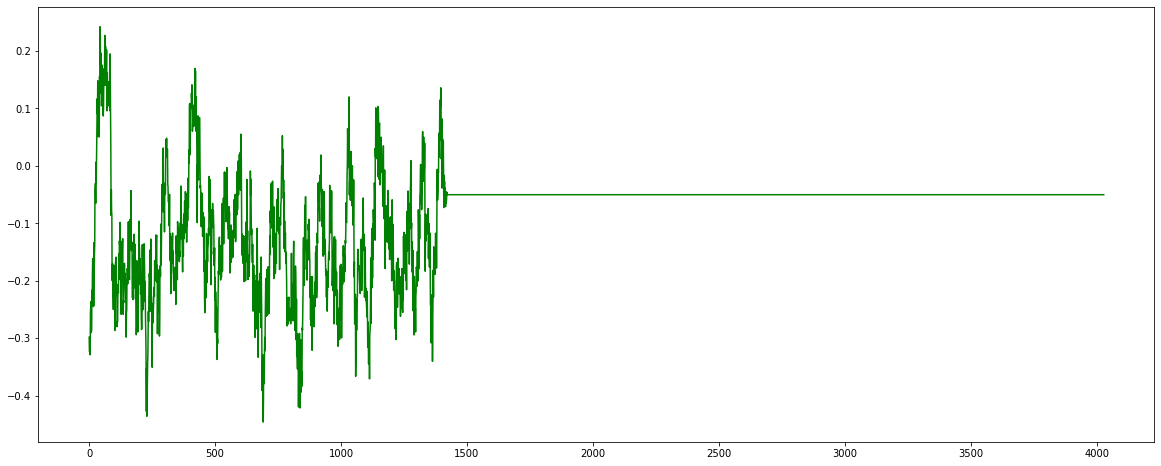


Window associated to the maximum output value (at position  43 ) is made by tokens:
[ 2201  6920     9   444     2    24   599     2   706     5    15  3199
     2  2958    22  7862    17  5406     3    35 67655    18  2490     2
 41390   752     6     4   610 12138 10003    60]
Mossos identifican el coche de una hija de Torra en un intento de cortar las vías del AVE #URL#> <El 61,7 por cien de encuestados cree que la sociedad balear “no” esta 
Window associated to the minimum output value (at position  691 ) is made by tokens:
[65624 69147 23861  1518  1382 17630   365     6 29599    53  4148  2358
     3   176   142  5231    20    15 15806 30335     7    85  7920    17
 52577    53  4148  2358     3 67318 50868 12765]
<Jover (Podemos): “Hemos perdido siete diputados. Hay que reflexionar” | CANAL4 DIARIO #URL#> <Una mujer agrede con un objeto punzante a dos técnicos del SAMU | CANAL4 DIARIO #URL#> <'GH VIP': Mila 

FILTER  26  OUTPUT: 


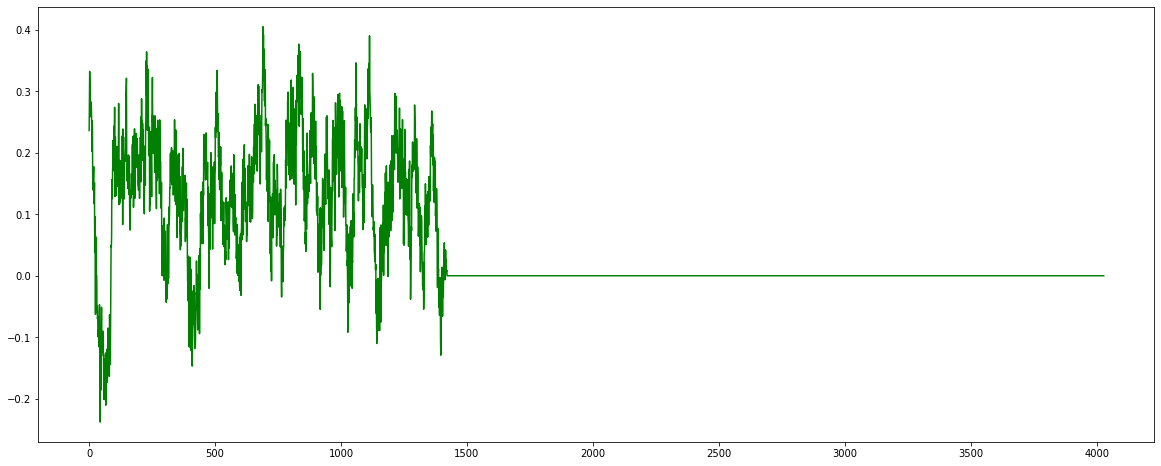


Window associated to the maximum output value (at position  690 ) is made by tokens:
[    3 65624 69147 23861  1518  1382 17630   365     6 29599    53  4148
  2358     3   176   142  5231    20    15 15806 30335     7    85  7920
    17 52577    53  4148  2358     3 67318 50868]
#URL#> <Jover (Podemos): “Hemos perdido siete diputados. Hay que reflexionar” | CANAL4 DIARIO #URL#> <Una mujer agrede con un objeto punzante a dos técnicos del SAMU | CANAL4 DIARIO #URL#> <'GH VIP': 
Window associated to the minimum output value (at position  44 ) is made by tokens:
[ 6920     9   444     2    24   599     2   706     5    15  3199     2
  2958    22  7862    17  5406     3    35 67655    18  2490     2 41390
   752     6     4   610 12138 10003    60 45058]
identifican el coche de una hija de Torra en un intento de cortar las vías del AVE #URL#> <El 61,7 por cien de encuestados cree que la sociedad balear “no” esta concienciada 

FILTER  27  OUTPUT: 


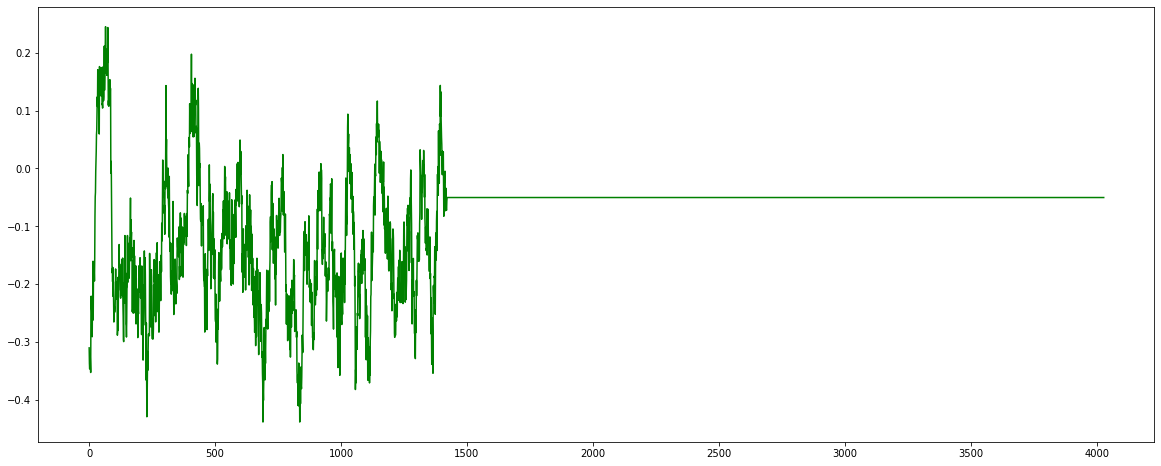


Window associated to the maximum output value (at position  65 ) is made by tokens:
[ 2490     2 41390   752     6     4   610 12138 10003    60 45058    20
     9  4539  1948     3 65613 10268     6     9   461     2  1490     5
   146  2645    15    89 14357     5   473     3]
cien de encuestados cree que la sociedad balear “no” esta concienciada con el bienestar animal #URL#> <JxCAT teme que el apoyo de ERC en Madrid incluye un nuevo tripartito en Cataluña #URL#> 
Window associated to the minimum output value (at position  836 ) is made by tokens:
[    3   249  2260 62554     2  2698    20  7189    53  5276 10972    29
  9626  9183     3 13622  1043   235     9  2974     2   103    98   921
    85  2941     2  6777     5 52240    18 67878]
#URL#> <Cómo preparar Atole de café con canela | Receta mexicana - Cocina Vital #URL#> <Amancio Ortega será el casero de Facebook tras comprar dos edificios de oficinas en Seattle por 375 

FILTER  28  OUTPUT: 


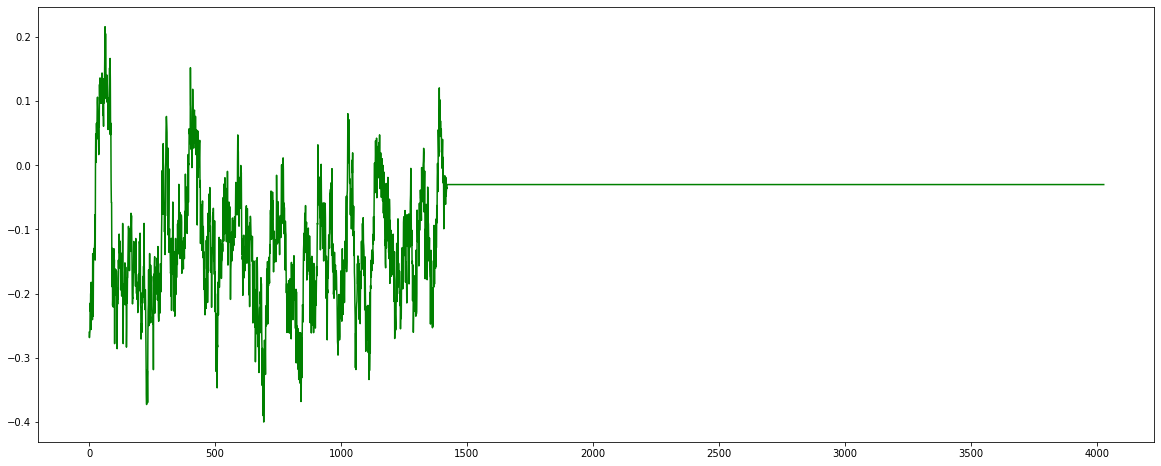


Window associated to the maximum output value (at position  63 ) is made by tokens:
[67655    18  2490     2 41390   752     6     4   610 12138 10003    60
 45058    20     9  4539  1948     3 65613 10268     6     9   461     2
  1490     5   146  2645    15    89 14357     5]
61,7 por cien de encuestados cree que la sociedad balear “no” esta concienciada con el bienestar animal #URL#> <JxCAT teme que el apoyo de ERC en Madrid incluye un nuevo tripartito en 
Window associated to the minimum output value (at position  693 ) is made by tokens:
[23861  1518  1382 17630   365     6 29599    53  4148  2358     3   176
   142  5231    20    15 15806 30335     7    85  7920    17 52577    53
  4148  2358     3 67318 50868 12765    23   440]
“Hemos perdido siete diputados. Hay que reflexionar” | CANAL4 DIARIO #URL#> <Una mujer agrede con un objeto punzante a dos técnicos del SAMU | CANAL4 DIARIO #URL#> <'GH VIP': Mila se queda 

FILTER  29  OUTPUT: 


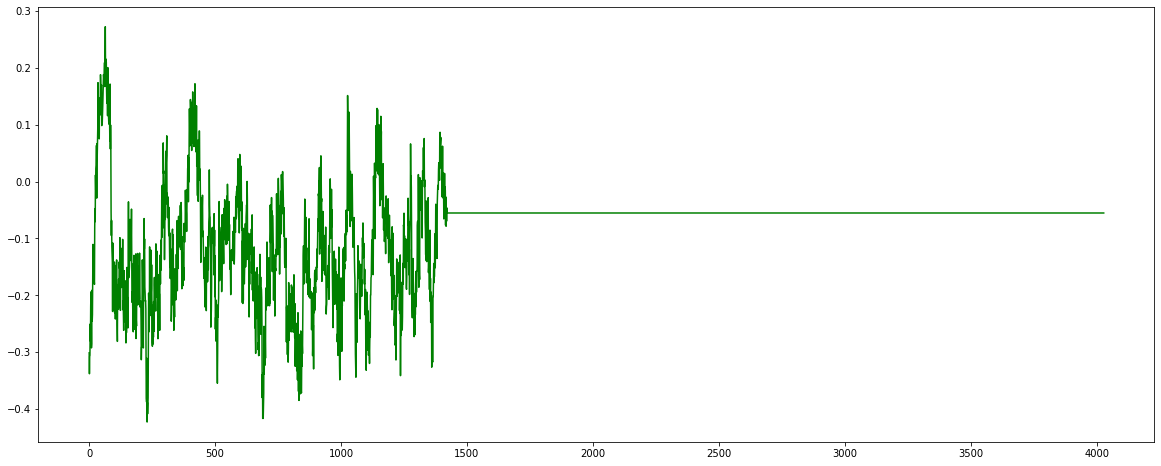


Window associated to the maximum output value (at position  64 ) is made by tokens:
[   18  2490     2 41390   752     6     4   610 12138 10003    60 45058
    20     9  4539  1948     3 65613 10268     6     9   461     2  1490
     5   146  2645    15    89 14357     5   473]
por cien de encuestados cree que la sociedad balear “no” esta concienciada con el bienestar animal #URL#> <JxCAT teme que el apoyo de ERC en Madrid incluye un nuevo tripartito en Cataluña 
Window associated to the minimum output value (at position  230 ) is made by tokens:
[ 3305 12829    53  4148  2358     3  3740 10401     7   133    18  8652
     9  3600  2816     3 66792 12856  1023    24 11294    55  1640     3
    39  3450     2   133    19 21116  8104     9]
Sant Llorenç | CANAL4 DIARIO #URL#> <Trump sancionará a Sánchez por financiar el comunismo venezolano #URL#> <Burger King lanza una hamburguesa sin carne #URL#> <La receta de Sánchez para Cataluña: reformar el 

FILTER  30  OUTPUT: 


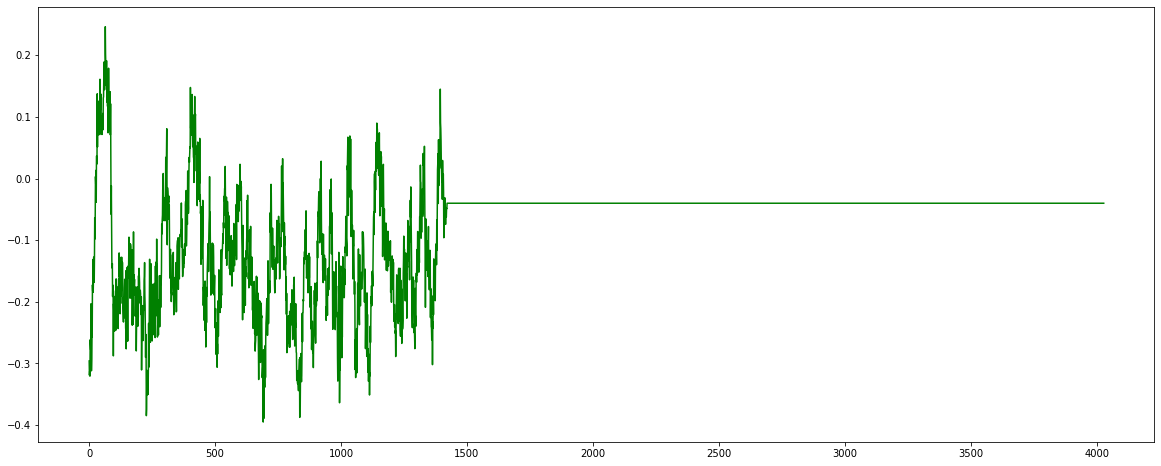


Window associated to the maximum output value (at position  64 ) is made by tokens:
[   18  2490     2 41390   752     6     4   610 12138 10003    60 45058
    20     9  4539  1948     3 65613 10268     6     9   461     2  1490
     5   146  2645    15    89 14357     5   473]
por cien de encuestados cree que la sociedad balear “no” esta concienciada con el bienestar animal #URL#> <JxCAT teme que el apoyo de ERC en Madrid incluye un nuevo tripartito en Cataluña 
Window associated to the minimum output value (at position  691 ) is made by tokens:
[65624 69147 23861  1518  1382 17630   365     6 29599    53  4148  2358
     3   176   142  5231    20    15 15806 30335     7    85  7920    17
 52577    53  4148  2358     3 67318 50868 12765]
<Jover (Podemos): “Hemos perdido siete diputados. Hay que reflexionar” | CANAL4 DIARIO #URL#> <Una mujer agrede con un objeto punzante a dos técnicos del SAMU | CANAL4 DIARIO #URL#> <'GH VIP': Mila 

FILTER  31  OUTPUT: 


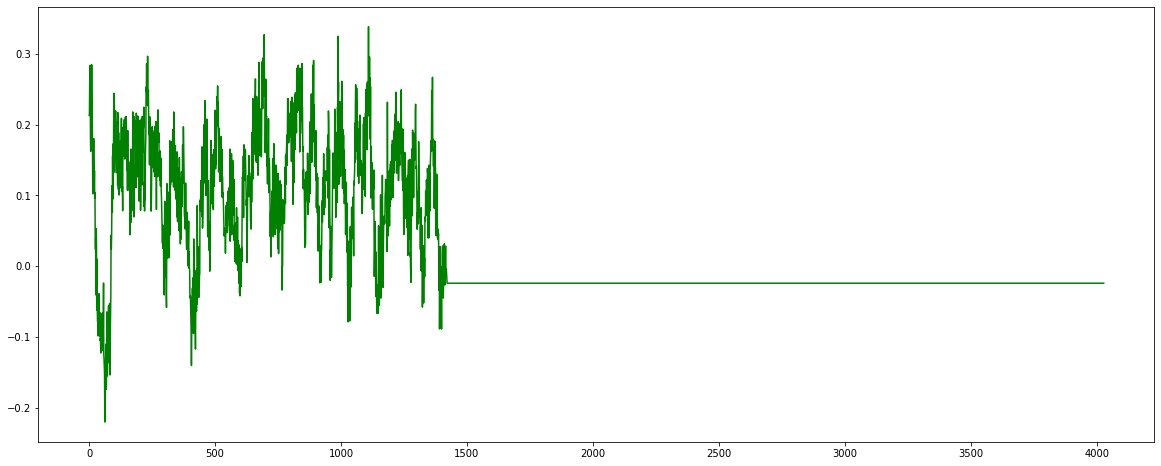


Window associated to the maximum output value (at position  1109 ) is made by tokens:
[40228     5 51336     5   326     3    35  3372   861    22  3543  4442
     2    22  3002 69820    39  4872     2  9667     4 14455  1762     6
  2501   294   434  1577    32  9411     3 13601]
excursionista en Tona, en Barcelona #URL#> <El ADN revela las flores favoritas de las abejas #URL#¡> <La ruina de Bolivia, la tiranía socialista que apoya Pablo Iglesias • El Matinal #URL#> <Bizcocho 
Window associated to the minimum output value (at position  62 ) is made by tokens:
[   35 67655    18  2490     2 41390   752     6     4   610 12138 10003
    60 45058    20     9  4539  1948     3 65613 10268     6     9   461
     2  1490     5   146  2645    15    89 14357]
<El 61,7 por cien de encuestados cree que la sociedad balear “no” esta concienciada con el bienestar animal #URL#> <JxCAT teme que el apoyo de ERC en Madrid incluye un nuevo tripartito 

FILTER  32  OUTPUT: 


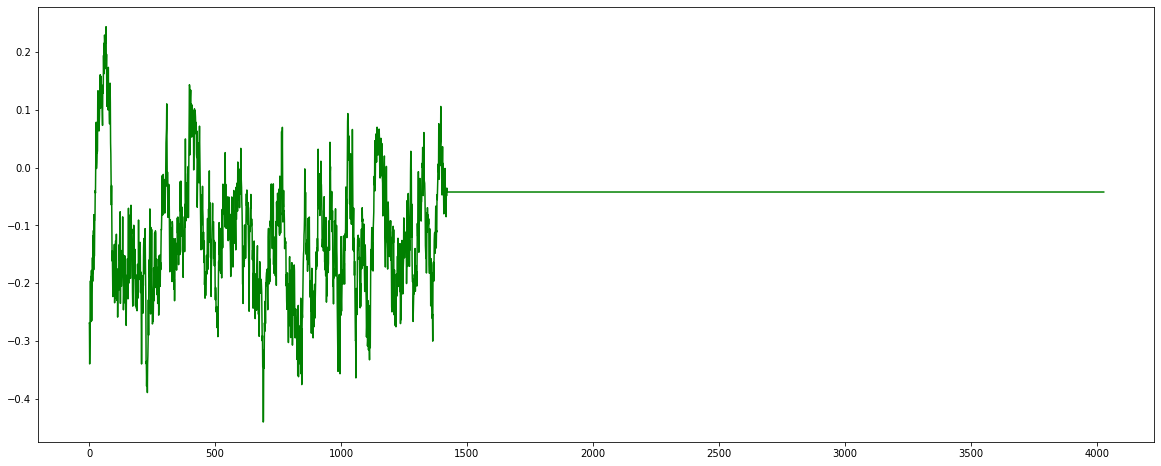


Window associated to the maximum output value (at position  67 ) is made by tokens:
[41390   752     6     4   610 12138 10003    60 45058    20     9  4539
  1948     3 65613 10268     6     9   461     2  1490     5   146  2645
    15    89 14357     5   473     3    93   272]
encuestados cree que la sociedad balear “no” esta concienciada con el bienestar animal #URL#> <JxCAT teme que el apoyo de ERC en Madrid incluye un nuevo tripartito en Cataluña #URL#> <Un joven 
Window associated to the minimum output value (at position  691 ) is made by tokens:
[65624 69147 23861  1518  1382 17630   365     6 29599    53  4148  2358
     3   176   142  5231    20    15 15806 30335     7    85  7920    17
 52577    53  4148  2358     3 67318 50868 12765]
<Jover (Podemos): “Hemos perdido siete diputados. Hay que reflexionar” | CANAL4 DIARIO #URL#> <Una mujer agrede con un objeto punzante a dos técnicos del SAMU | CANAL4 DIARIO #URL#> <'GH VIP': Mila 



In [ ]:
xAxis=[0]
plt.rcParams["figure.figsize"] = (20,8)

for i in range(1,4029):
    xAxis.append(i)

for element in raw_train_ds:
  authorDocument=element[0]
  label=element[1]
  
  print("Sample considered is: ", authorDocument[0])
  print("Preprocessed: ", str(custom_standardization(authorDocument[0].numpy())))
  print("And has label: ", label[0].numpy())

  text_vect_layer_model = tf.keras.Model(inputs=model.input,
                                       outputs=model.get_layer('text_vectorization').output)
  text_vect_out = text_vect_layer_model(authorDocument)

  first_conv1d_layer_model = tf.keras.Model(inputs=model.input,
                                       outputs=model.get_layer('conv1d_14').output)
  first_conv1d_out = first_conv1d_layer_model(authorDocument)

  conv1dOutput=[]
  textVectOutput=[]

  for filterNr in range(0,32):   
    mostImportantTokens=[]
    lessImportantTokens=[] 
    maxY=first_conv1d_out[0][0][filterNr].numpy()
    minY=first_conv1d_out[0][0][filterNr].numpy()
    indexMax=0
    indexMin=0
    yAxis=[]
    for y in range (0,4029):
      if first_conv1d_out[0][y][filterNr].numpy()>maxY:
        indexMax=y
        maxY=first_conv1d_out[0][y][filterNr].numpy()
      if first_conv1d_out[0][y][filterNr].numpy()<minY:
        indexMin=y
        minY=first_conv1d_out[0][y][filterNr].numpy()
      yAxis.append(first_conv1d_out[0][y][filterNr].numpy())

    mostImportantTokens=text_vect_out[0][indexMax:indexMax+32].numpy()
    lessImportantTokens=text_vect_out[0][indexMin:indexMin+32].numpy()

    print("\n\nFILTER ",(filterNr+1), " OUTPUT: ")
    plt.plot(xAxis, yAxis,color='green', label="line L")
    plt.show()
    
    print("\nWindow associated to the maximum output value (at position ",indexMax,") is made by tokens:")
    print(mostImportantTokens)
    for i in range(0,32):
      print(vectorize_layer.get_vocabulary()[mostImportantTokens[i]],end=' ')

    print("\nWindow associated to the minimum output value (at position ",indexMin,") is made by tokens:")
    print(lessImportantTokens)
    for i in range(0,32):
      print(vectorize_layer.get_vocabulary()[lessImportantTokens[i]],end=' ')

  print("\n")
 
  break

##Reload test set and print wrong predictions.



In [ ]:
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    test_dir+language, 
    batch_size=1
    )

wrong_prediction_counter=0

for element in raw_test_ds:
  authorDocument=element[0]
  
  output_layer_model = tf.keras.Model(inputs=model.input,
                                       outputs=model.get_layer('dense_7').output)
  output = output_layer_model(authorDocument)  

  if (float(output)>0 and int(element[1][0]!=1)) or (float(output)<0 and int(element[1][0]!=0)) :
    print("\nFor document:")
    print(authorDocument[:1])
    print("True label is:")
    print(int(element[1][0]))
    print("Predicted is:")
    print(float(output))
    wrong_prediction_counter=wrong_prediction_counter+1
    print("Wrong predictions now are:")
    print(wrong_prediction_counter)
